# Assignment 05

**Citation:** The following questions and supporting code were originally developed as part of Dr. Eric Eaton's [Introduction to Machine Learning Course at U Penn](https://www.cis.upenn.edu/~cis5190/fall2014/). 


In [66]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import itertools

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset, random_split 

from utils import load_dataset

from time import time

**1.1** $k$-Means Clustering


Given a dataset $x_1,..., x_n \in \mathbb{R}^{d}$ and an integer $1 \leq k \leq n$, recall the following $k$-means objective function
\begin{align}
    \min_{\pi_1, ..., \pi_k} \sum_{i=1}^{k} \sum_{j \in \pi_i} \| x_j - \mu_{i} \|_{2}^{2} \ , \quad \mu_i = \frac{1}{|\pi_i|} \sum_{j \in \pi_i} x_j \ .
\end{align}

Above, $\{\pi_i\}_{i=1}^{k}$ is a partition of $\{1, 2, ..., n\}$. The objective function above is NP-hard (To be more precise, it is both NP-hard in $d$ when $k=2$ and $k$ when $d=2$. See the references on the wikipedia page for $k$-means for more details. to find a global minimizer of. Nevertheless the commonly-used algorithm we discussed in lecture (Lloyd's algorithm), typically works well in practice.)


**Note on Time to Run** --- The runtime of a good implementation for this problem should be fairly fast (a few minutes); if you find it taking upwards of one hour, please check your implementation! (Hint: **For loops are costly.** Can you vectorize it or use Numpy operations to make it faster in some ways? If not, is looping through data-points or through centers faster?)



**a.** [5 points] The $k$-Means clustering algorithm we covered in class is called Lloyd's algorithm.  Implement Lloyd's algorithm for solving the $k$-means objective above. Do not use any off-the-shelf implementations, such as those found in ```scikit-learn```. Include your code in your submission.
    
**b.** [5 points] Run the algorithm on the *training* dataset of MNIST with $k=10$. Visualize (and include in your report) the cluster centers as a set of $k$ $28\times 28$ images.

**c.** [5 points] For $k=\{2, 4, 8, 16, 32, 64\}$ run the algorithm on the *training* dataset to obtain centers $\{\mu_{i}\}_{i=1}^k$. If $\{(x_i,y_i)\}_{i=1}^n$ and $\{(x_i',y_i')\}_{i=1}^m$ denote the training and test sets, respectively, plot the training error $\frac{1}{n} \sum_{i=1}^n \min_{j=1,\dots,k} \| \mu_j - x_i \|_2$ and test error $\frac{1}{m} \sum_{i=1}^m \min_{j=1,\dots,k} \| \mu_j - x_i' \|_2$ as a function of $k$ on the same plot.

**What to Submit:**
 - **For part (a):** Lloyd's algorithm code
 - **For part (b):** 10 images of cluster centers.
 - **For part (c):** Plot of training and test error as function of k.
 - Code in this jupyter notebook

In [ ]:
# def calculate_centers(
#     data: np.ndarray, classifications: np.ndarray, num_centers: int
# ) -> np.ndarray:
#     """
#     Sub-routine of Lloyd's algorithm that calculates the centers given datapoints and their respective classifications/assignments.
#     num_centers is additionally provided for speed-up purposes.

#     Args:
#         data (np.ndarray): Array of shape (n, d). Training data set.
#         classifications (np.ndarray): Array of shape (n,) full of integers in range {0, 1, ...,  num_centers - 1}.
#             Data point at index i is assigned to classifications[i].
#         num_centers (int): Number of centers for reference.
#             Might be usefull for pre-allocating numpy array (Faster that appending to list).

#     Returns:
#         np.ndarray: Array of shape (num_centers, d) containing new centers.
#     """
#     # Initialize centers with zeros
#     centers = np.zeros((num_centers, data.shape[1]))

#     # Update the cluster centers based on the current assignment of data point
#     for cluster_index in range(num_centers):
#         cluster_points = data[classifications == cluster_index]
#         if len(cluster_points) > 0:  # Avoid division by zero for empty clusters
#             centers[cluster_index] = cluster_points.mean(axis=0)
#     return centers
#     # raise NotImplementedError("Your Code Goes Here")

# def calculate_centers(data, classifications, num_centers):
#     """Calculates cluster centers by looping through centers."""
#     centers = np.zeros((num_centers, data.shape[1]))
#     cluster_counts = np.zeros(num_centers)

#     # Loop through centers and accumulate data points
#     for center_index in range(num_centers):
#         # Find data points belonging to the current center
#         data_points_indices = np.where(classifications == center_index)[0]
        
#         # Update center and count if data points are found
#         if len(data_points_indices) > 0:
#             centers[center_index] = np.mean(data[data_points_indices], axis=0)
#             cluster_counts[center_index] = len(data_points_indices)

#     return centers

def calculate_centers(data, classifications, num_centers, batch_size=500):
    """Calculates cluster centers using batch processing."""
    centers = np.zeros((num_centers, data.shape[1]))
    cluster_counts = np.zeros(num_centers)
    num_batches = int(np.ceil(data.shape[0] / batch_size))

    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min(start_index + batch_size, data.shape[0])
        batch_data = data[start_index:end_index]
        batch_classifications = classifications[start_index:end_index]

        # Update centers and counts for the current batch
        for center_index in range(num_centers):
            data_points_indices = np.where(batch_classifications == center_index)[0]
            if len(data_points_indices) > 0:
                centers[center_index] += np.sum(batch_data[data_points_indices], axis=0)
                cluster_counts[center_index] += len(data_points_indices)

    # Calculate final centers by dividing accumulated sums by counts
    centers = np.divide(centers, cluster_counts[:, np.newaxis], out=np.zeros_like(centers), where=cluster_counts[:, np.newaxis] != 0)

    return centers



def cluster_data_og(data: np.ndarray, centers: np.ndarray) -> np.ndarray:
    """
    Sub-routine of Lloyd's algorithm that clusters datapoints to centers given datapoints and centers.

    Args:
        data (np.ndarray): Array of shape (n, d). Training data set.
        centers (np.ndarray): Array of shape (k, d). Each row is a center to which a datapoint can be clustered.

    Returns:
        np.ndarray: Array of integers of shape (n,), with each entry being in range {0, 1, 2, ..., k - 1}.
            Entry j at index i should mean that j^th center is the closest to data[i] datapoint.
    """
    # Calculate distances between data points and centers using broadcasting
    distances = np.linalg.norm(data[:, np.newaxis, :] - centers, axis=2)
    
    # Assign each data point to the cluster with the nearest center
    classifications = np.argmin(distances, axis=1)

    return classifications
    # raise NotImplementedError("Your Code Goes Here")

def cluster_data(data, centers, batch_size=500):
    """Assigns data points to clusters using batch processing."""
    num_batches = int(np.ceil(data.shape[0] / batch_size))
    classifications = np.zeros(data.shape[0], dtype=int)

    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min(start_index + batch_size, data.shape[0])
        batch_data = data[start_index:end_index]

        # Assign data points in the current batch to clusters
        batch_classifications = cluster_data_og(batch_data, centers)  # Use original cluster_data function

        # Update classifications for the current batch
        classifications[start_index:end_index] = batch_classifications

    return classifications


def calculate_error(data: np.ndarray, centers: np.ndarray) -> float:
    """Calculates error/objective function on a provided dataset, with trained centers.

    Args:
        data (np.ndarray): Array of shape (n, d). Dataset to evaluate centers on.
        centers (np.ndarray): Array of shape (k, d). Each row is a center to which a datapoint can be clustered.
            These should be trained on training dataset.

    Returns:
        float: Single value representing mean objective function of centers on a provided dataset.
    """
    classifications = cluster_data(data, centers)  
    error = np.mean(np.sum((data - centers[classifications])**2, axis=1))

    return error
    # raise NotImplementedError("Your Code Goes Here")


def lloyd_algorithm(
    data: np.ndarray, num_centers: int, epsilon: float = 10e-3
) -> np.ndarray:
    """Main part of Lloyd's Algorithm.

    Args:
        data (np.ndarray): Array of shape (n, d). Training data set.
        num_centers (int): Number of centers to train/cluster around.
        epsilon (float, optional): Epsilon for stopping condition.
            Training should stop when max(abs(centers - previous_centers)) is smaller or equal to epsilon.
            Defaults to 10e-3.

    Returns:
        np.ndarray: Array of shape (num_centers, d) containing trained centers.

    Note:
        - For initializing centers please use the first `num_centers` data points.
    """
    # Initialize centers using the first num_centers data points
    centers = data[:num_centers]
    previous_centers = np.zeros_like(centers)

    while np.max(np.abs(centers - previous_centers)) > epsilon:
        previous_centers = centers.copy()
        classifications = cluster_data(data, centers)
        centers = calculate_centers(data, classifications, num_centers)

    return centers
    # raise NotImplementedError("Your Code Goes Here")

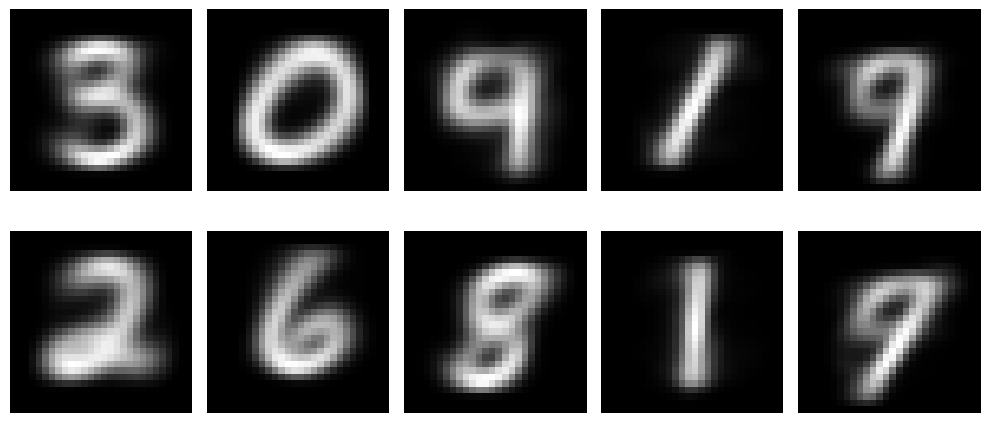

  0%|          | 0/6 [00:00<?, ?it/s]

Time taken for k=2: 1.87 seconds


 17%|█▋        | 1/6 [00:02<00:10,  2.14s/it]

Time taken for train error calculation: 0.22 seconds
Time taken for test error calculation: 0.04 seconds
Time taken for k=4: 2.82 seconds


 33%|███▎      | 2/6 [00:05<00:11,  2.76s/it]

Time taken for train error calculation: 0.32 seconds
Time taken for test error calculation: 0.05 seconds
Time taken for k=8: 12.59 seconds


 50%|█████     | 3/6 [00:18<00:22,  7.61s/it]

Time taken for train error calculation: 0.68 seconds
Time taken for test error calculation: 0.11 seconds
Time taken for k=16: 39.64 seconds
Time taken for train error calculation: 1.30 seconds


 67%|██████▋   | 4/6 [00:59<00:41, 20.85s/it]

Time taken for test error calculation: 0.22 seconds
Time taken for k=32: 153.47 seconds
Time taken for train error calculation: 2.68 seconds


 83%|████████▎ | 5/6 [03:36<01:09, 69.80s/it]

Time taken for test error calculation: 0.45 seconds
Time taken for k=64: 412.63 seconds
Time taken for train error calculation: 6.40 seconds


100%|██████████| 6/6 [10:36<00:00, 106.09s/it]

Time taken for test error calculation: 1.05 seconds


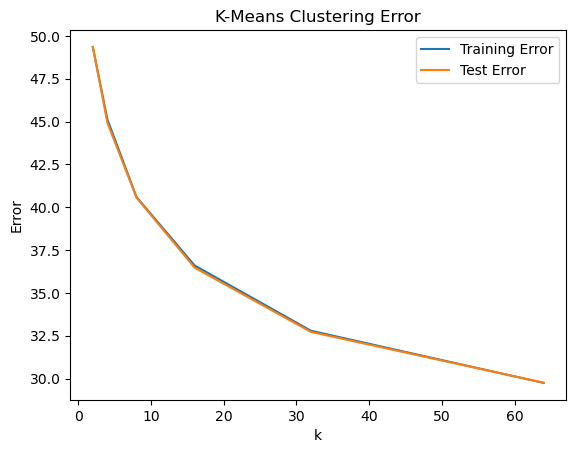

In [5]:
def main():
    """Main function of k-means problem

    You should:
        a. Run Lloyd's Algorithm for k=10, and report 10 centers returned.
        b. For ks: 2, 4, 8, 16, 32, 64 run Lloyd's Algorithm,
            and report objective function value on both training set and test set.
            (All one plot, 2 lines)

    NOTE: This code takes a while to run. For debugging purposes you might want to change:
        x_train to x_train[:10000]. CHANGE IT BACK before submission.
    """
    (x_train, _), (x_test, _) = load_dataset("mnist")

    # Part a: Run Lloyd's Algorithm for k=10 
    centers_k10 = lloyd_algorithm(x_train, num_centers=10)

    # Reshape centers to display as images
    centers_k10_images = centers_k10.reshape(10, 28, 28)  
    
    # Display centers as images
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # Create a 2x5 grid of subplots
    axes = axes.ravel()  # Flatten the axes array for easier iteration

    for i in range(10):
        axes[i].imshow(centers_k10_images[i], cmap="gray")  # Display each center as a grayscale image
        axes[i].axis("off")  # Turn off axis labels and ticks

    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.show()  # Display the plot

    # Part b: Run Lloyd's Algorithm for different k values and plot errors
    # k_values = [2, 4, 8, 16]
    k_values = [2, 4, 8, 16, 32, 64]
    train_errors = []
    test_errors = []

    for k in tqdm(k_values):
        time_start = time()
        centers = lloyd_algorithm(x_train, num_centers=k)
        time_end = time()
        print(f"Time taken for k={k}: {time_end - time_start:.2f} seconds")

        time_start = time()
        train_errors.append(calculate_error(x_train, centers))
        time_end = time()
        print(f"Time taken for train error calculation: {time_end - time_start:.2f} seconds")

        time_start = time()
        test_errors.append(calculate_error(x_test, centers))
        time_end = time()
        print(f"Time taken for test error calculation: {time_end - time_start:.2f} seconds")

    # Plot training and test errors as a function of k
    plt.plot(k_values, train_errors, label="Training Error")
    plt.plot(k_values, test_errors, label="Test Error")
    plt.xlabel("k")
    plt.ylabel("Error")
    plt.legend()
    plt.title("K-Means Clustering Error")
    plt.show()

    # raise NotImplementedError("Your Code Goes Here")

if __name__ == "__main__":
    main()



**1.2** PCA

Let's do PCA on MNIST dataset and reconstruct the digits in the dimensionality-reduced PCA basis. You will compute your PCA basis using the training dataset only, and evaluate the quality of the basis on the test set, similar to the k-means reconstructions above. 
We have $n_{train}=50,000$ training examples of size $28 \times 28$. Begin by flattening each example to a vector to obtain $X_{train} \in \mathbb{R}^{50,000 \times d}$ and $X_{test} \in \mathbb{R}^{10,000 \times d}$ for $d= 784$.

Let $\mu \in \mathbb{R}^{d}$ denote the average of the training examples in $X_{train}$, i.e., $\mu = \frac{1}{n_{train}} X_{train}^\top \mathbf{1}^\top$. Now let $\Sigma =  (X_{train} - \mathbf{1} \mu^\top)^\top (X_{train} - \mathbf{1} \mu^\top)/50000$ denote the sample covariance matrix of the training examples, and let $\Sigma = UDU^T$ denote the eigenvalue decomposition of $\Sigma$.


**a.** [2 points]
    If $\lambda_i$ denotes the $i$th largest eigenvalue of $\Sigma$, what are the eigenvalues $\lambda_1$, $\lambda_2$, $\lambda_{10}$, $\lambda_{30}$, and $\lambda_{50}$? What is the sum of eigenvalues $\sum_{i=1}^d{\lambda_i}$?
 
**b.** [5 points]
    Let $x \in \mathbb{R}^d$ and $k \in 1,2,\dots,d$. Write a formula for the rank-$k$ PCA approximation of $x$.
 
**c.** [5 points] Using this approximation, plot the reconstruction error from $k=1$ to $100$ (the $X$-axis is $k$ and the $Y$-axis is the mean-squared error reconstruction error) on the training set and the test set (using the $\mu$ and the basis learned from the training set). 
    On a separate plot, plot  $1-\frac{\sum_{i=1}^{k}{\lambda_i}}{\sum_{i=1}^{d}{\lambda_i}}$ from $k=1$ to $100$.
    
**d.** [3 points]
    Now let us get a sense of what the top PCA directions are capturing. Display the first $10$ eigenvectors as images, and provide a brief interpretation of what you think they capture.
    
**e.** [3 points]
    Finally, visualize a set of reconstructed digits from the training set for different values of $k$. In particular provide the reconstructions for digits $2,6,7$ with values $k = 5, 15, 40, 100$ (just choose an image from each digit arbitrarily). Show the original image side-by-side with its reconstruction. Provide a brief interpretation, in terms of your perceptions of the quality of these reconstructions and the dimensionality you used.
    
**What to Submit:**

- **For part (a):** Eigenvalues 1, 2, 10, 30, and 50 and the sum. At least 6 leading digits.
- **For part (b):** The Formula. If you are defining new variables/matrices make sure their definition is stated
        clearly.
- **For part (c):** Plot containing reconstruction error on train and test sets. Plot of $1-\frac{\sum_{i=1}^{k}{\lambda_i}}{\sum_{i=1}^{d}{\lambda_i}}$
- **For part (d):** 10 eigenvectors as images.
- **For part (e):** 15 total images, including 3 original and 12 reconstructed ones. Each reconstructed image
        corresponds to a certain digit (2, 6 or 7) and k value (5, 15, 40 or 100).
- Code for parts c-e in this jupyter notebook.

In [69]:
def reconstruct_demean(uk: np.ndarray, demean_data: np.ndarray) -> np.ndarray:
    """Given a demeaned data, create a recontruction using eigenvectors provided by `uk`.

    Args:
        uk (np.ndarray): First k eigenvectors. Shape (d, k).
        demean_vec (np.ndarray): Demeaned data (centered at 0). Shape (n, d)

    Returns:
        np.ndarray: Array of shape (n, d).
            Each row should correspond to row in demean_data,
            but first compressed and then reconstructed using uk eigenvectors.
    """
    return demean_data @ uk @ uk.T
    # raise NotImplementedError("Your Code Goes Here")



def reconstruction_error(uk: np.ndarray, demean_data: np.ndarray) -> float:
    """Given a demeaned data and some eigenvectors calculate the squared L-2 error that recontruction will incur.

    Args:
        uk (np.ndarray): First k eigenvectors. Shape (d, k).
        demean_data (np.ndarray): Demeaned data (centered at 0). Shape (n, d)

    Returns:
        float: Squared L-2 error on reconstructed data.
    """
    error = np.mean(np.sum((demean_data - demean_data @ uk @ uk.T) ** 2, axis=1))
    return error
    # raise NotImplementedError("Your Code Goes Here")


def calculate_eigen(demean_data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given demeaned data calculate eigenvalues and eigenvectors of it.

    Args:
        demean_data (np.ndarray): Demeaned data (centered at 0). Shape (n, d)

    Returns:
        Tuple[np.ndarray, np.ndarray]: Tuple of two numpy arrays representing:
            1. Eigenvalues array with shape (d,)
            2. Matrix with eigenvectors as columns with shape (d, d)
    """
    cov = np.cov(demean_data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors
    # raise NotImplementedError("Your Code Goes Here")

def main():
    """
    Main function of PCA problem. It should load data, calculate eigenvalues/-vectors,
    and then answer all questions from problem statement.

    Part A:
        - Report 1st, 2nd, 10th, 30th and 50th largest eigenvalues
        - Report sum of eigenvalues

    Part C:
        - Plot reconstruction error as a function of k (# of eigenvectors used)
            Use k from 1 to 101.
            Plot should have two lines, one for train, one for test.
        - Plot ratio of sum of eigenvalues remaining after k^th eigenvalue with respect to whole sum of eigenvalues.
            Use k from 1 to 101.

    Part D:
        - Visualize 10 first eigenvectors as 28x28 grayscale images.

    Part E:
        - For each of digits 2, 6, 7 plot original image, and images reconstruced from PCA with
            k values of 5, 15, 40, 100.
    """
    # PART A
    
    (x_train, y_train), (x_test, y_test) = load_dataset("mnist")
    X_train = x_train.reshape(x_train.shape[0], -1)  # Flatten data
    mu = np.mean(X_train, axis=0)
    demean_data = X_train - mu
    # cov = np.cov(demean_data, rowvar=False)
    # eigenvalues, eigenvectors = np.linalg.eigh(cov)
    eigenvalues, eigenvectors = calculate_eigen(demean_data)
    print("Eigenvalue 1:", eigenvalues[0])
    print("Eigenvalue 2:", eigenvalues[1])
    print("Eigenvalue 10:", eigenvalues[9])
    print("Eigenvalue 30:", eigenvalues[29])
    print("Eigenvalue 50:", eigenvalues[49])
    print("Sum of eigenvalues:", np.sum(eigenvalues))

    # PART C
    # Plot reconstruction error as a function of k
    k_values = np.arange(1, 101)
    train_errors = []
    test_errors = []
    for k in k_values:
        train_reconstructed = reconstruct_demean(eigenvectors[:, :k], demean_data)
        train_errors.append(reconstruction_error(eigenvectors[:, :k], demean_data))
        test_reconstructed = reconstruct_demean(eigenvectors[:, :k], x_test.reshape(x_test.shape[0], -1) - mu)
        test_errors.append(reconstruction_error(eigenvectors[:, :k], x_test.reshape(x_test.shape[0], -1) - mu))

    # Plot reconstruction errors
    plt.plot(k_values, train_errors, label="Train Error")
    plt.plot(k_values, test_errors, label="Test Error")
    plt.xlabel("k")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    
    plt.show()
    
    # Plot ratio of sum of eigenvalues remaining after k^th eigenvalue
    # with respect to whole sum of eigenvalues.
    ratio_remaining = 1 - (np.cumsum(eigenvalues) / np.sum(eigenvalues))
    plt.plot(k_values, ratio_remaining[:100], label="Remaining Eigenvalues Ratio")
    plt.xlabel("k")
    plt.ylabel("Ratio of Remaining Eigenvalues")
    plt.legend()
    plt.show()

    # PART D
    # Visualize 10 first eigenvectors as 28x28 grayscale images.
    eigenvectors_images = eigenvectors[:, :10].reshape(28, 28, 10)
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # Create a 2x5 grid of subplots
    axes = axes.ravel()  # Flatten the axes array for easier iteration
    for i in range(10):
        axes[i].imshow(eigenvectors_images[:, :, i], cmap="gray")  # Display each eigenvector as a grayscale image
        axes[i].axis("off")  # Turn off axis labels and ticks
    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.show()  # Display the plot

    # PART E
    # For each of digits 2, 6, 7 plot original image, and images reconstructed from PCA with k values of 5, 15, 40, 100.
    digits_to_visualize = [2, 6, 7]
    k_values = [5, 15, 32, 40, 64, 100, 128] # 32 64 128 for 1.3

    for digit in digits_to_visualize:
        # Find index of digit in training set
        digit_index = np.argwhere(y_train == digit)[0][0]

        # Original image
        original_image = x_train[digit_index].reshape(28, 28)
        
        # plt.imshow(original_image, cmap="gray")
        # plt.title(f"Original Image of Digit {digit}")
        # plt.axis("off")
        # plt.show()
        # # Reconstructed images
        
        # for k in k_values:
        #     reconstructed_image = reconstruct_demean(eigenvectors[:, :k], original_image.flatten() - mu)
        #     reconstructed_image = reconstructed_image.reshape(28, 28)
        #     plt.imshow(reconstructed_image, cmap="gray")
        #     plt.title(f"Reconstructed Image of Digit {digit} with k={k}")
        #     plt.axis("off")
        #     plt.show()

        reconstructed_images = []
        for k in k_values:
            reconstructed_image = reconstruct_demean(eigenvectors[:, :k], original_image.flatten() - mu)
            reconstructed_image = reconstructed_image.reshape(28, 28)
            reconstructed_images.append(reconstructed_image)

        # Display original and reconstructed images in one row
        fig, axes = plt.subplots(1, len(k_values) + 1, figsize=(15, 5))
        axes[0].imshow(original_image, cmap="gray")
        axes[0].set_title(f"Original Digit: {digit}")
        axes[0].axis("off")  # Turn off axis for original image

        for i, k in enumerate(k_values):
            axes[i + 1].imshow(reconstructed_images[i], cmap="gray")
            axes[i + 1].set_title(f"k = {k}")
            axes[i + 1].axis("off")  # Turn off axis for reconstructed images

        plt.show()    


Eigenvalue 1: 5.11687300955891
Eigenvalue 2: 3.741390835378725
Eigenvalue 10: 1.2427500889188117
Eigenvalue 30: 0.36426179130874503
Eigenvalue 50: 0.1697112555276528
Sum of eigenvalues: 52.725914260364505


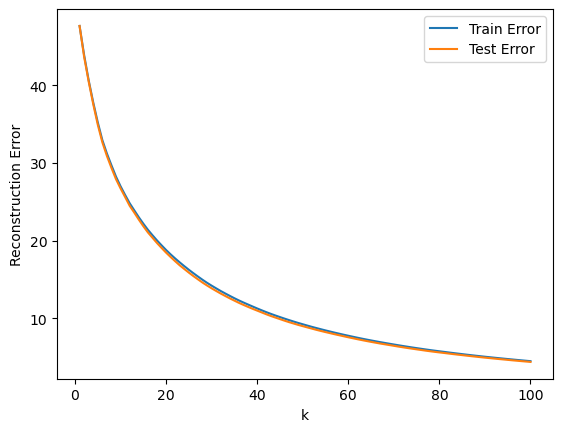

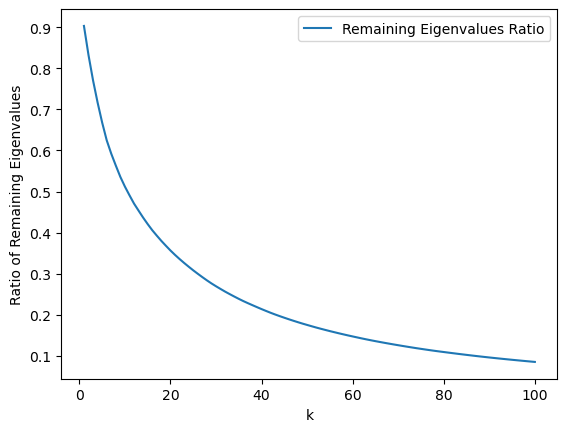

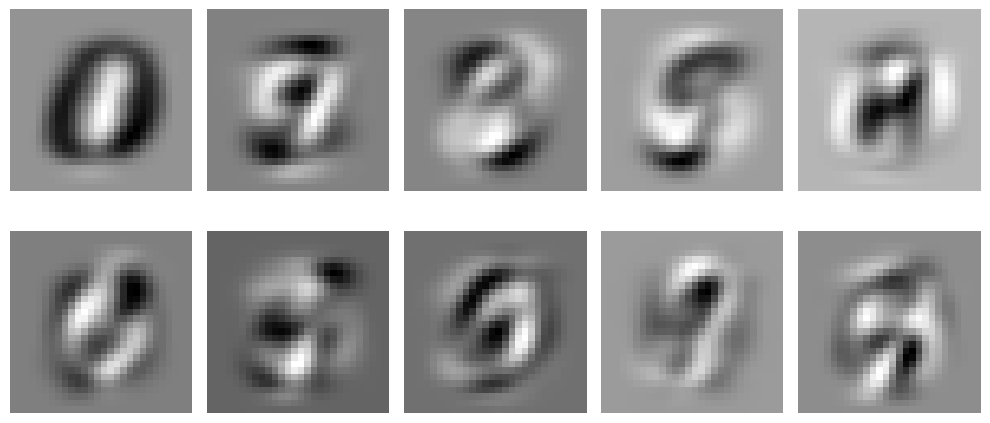

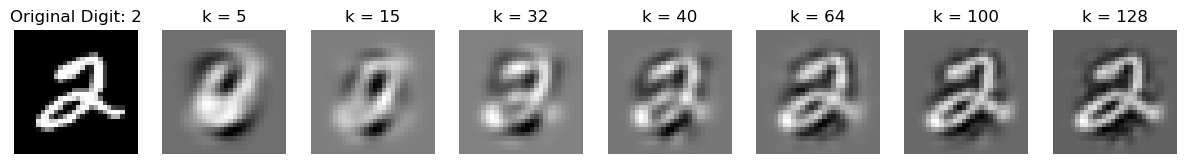

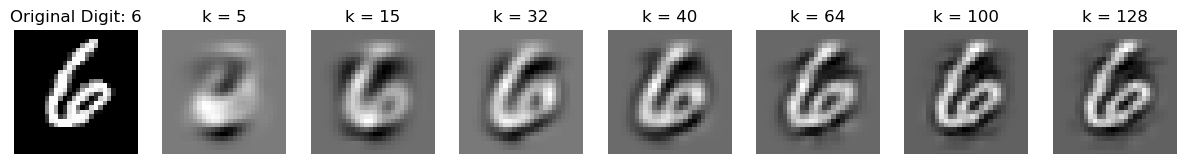

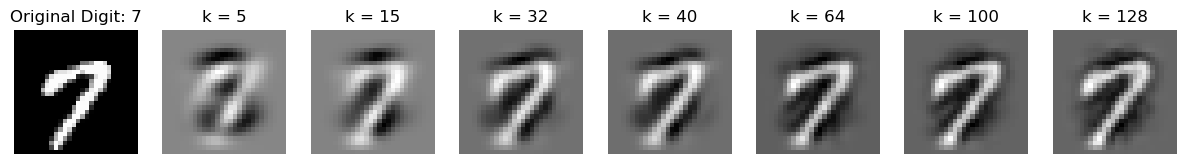

In [70]:
if __name__ == "__main__":
    main()


**1.3** Unsupervised Learning with Autoencoders

In this exercise, we will train two simple autoencoders to perform dimensionality reduction on MNIST. As discussed in lecture, autoencoders are a long-studied neural network architecture comprised of an encoder component to summarize the latent features of input data and a decoder component to try and reconstruct the original data from the latent features.

**Weight Initialization and PyTorch**
Last assignment, we had you refrain from using ```torch.nn``` modules. For this assignment, we will use these modules, and recommend using ```nn.Linear``` for your linear layers. You will not need to initialize the weights yourself; the default initialization in PyTorch will be sufficient for this problem. *Hint: we also recommend using the ```nn.Sequential``` module to organize your network class and simplify the process of writing the forward pass. However, you may choose to organize your code however you'd like.*

**Training**
Use ```optim.Adam``` for this question. Feel free to experiment with different learning rates, though you can use $5 \cdot 10^{-5}$ as mentioned in the code. Use mean
squared error (```nn.MSELoss()``` or ```F.mse_loss()```) for the loss function.


**a.** [10 points] Use a network with a single linear layer. Let $W_{\text{e}} \in \mathbb{R}^{h \times d}$ and $W_{\text{d}} \in \mathbb{R}^{d\times h}$. Given some $x \in \mathbb{R}^d$, the forward pass is formulated as 

$$
      \mathcal{F}_{1}(x) = W_{\mathrm{d}} W_{\mathrm{e}} x.
$$

Run experiments for $h \in \{ 32, 64, 128 \}$. For each of the different $h$ values, report your final training error and visualize a set of 10 reconstructed digits, side-by-side with the original image. *Note:* we omit the bias term in the formulation for notational convenience since ```nn.Linear``` learns bias parameters alongside weight parameters by default.
    
**b.** [10 points] Use a single-layer network with non-linearity. Let $W_{\mathrm{e}} \in \mathbb{R}^{h \times d}$, $W_{\mathrm{d}} \in \mathbb{R}^{d\times h}$, and activation $\sigma: \mathbb{R} \longmapsto \mathbb{R}$, where $\sigma$ is the ReLU function. Given some $x \in \mathbb{R}^d$, the forward pass is formulated as 

$$
      \mathcal{F}_{2}(x) = \sigma(W_{\text{d}} \sigma(W_{\mathrm{e}} x)).
$$

Report the same findings as asked for in part a (for $h \in \{ 32,64,128 \}$).
    
**c.** [5 points] Now, evaluate $\mathcal{F}_1(x)$ and $\mathcal{F}_2(x)$ (use $h=128$ here) on the test set. Provide the test reconstruction errors in a table.
    
**d.** [5 points] In a few sentences, compare the quality of the reconstructions from these two autoencoders with those of PCA from problem A5. You may need to re-run your code for PCA using the ranks $k \in \{32, 64, 128\}$ to match the $h$ values used above.
\end{enumerate}
 
**What to Submit:**


- **For parts (a, b):** Final training error and set of 10 reconstructed images of digits, side-by-side with the
original image (10 images for each h).
- **For part (c):** Errors of networks from part a and b on testing set.
- **For part (d):** 2-3 sentences on differences in quality of solutions between PCA and Autoencoders, with
example images
- Code for parts a-c


In [ ]:
def F1(h: int) -> nn.Module:
    """Model F1, it should performs an operation W_d * W_e * x as written in spec.

    Note:
        - While bias is not mentioned explicitly in equations above, it should be used.
            It is used by default in nn.Linear which you can use in this problem.

    Args:
        h (int): Dimensionality of the encoding (the hidden layer).

    Returns:
        nn.Module: An initialized autoencoder model that matches spec with specific h.
    """
    F1 = nn.Sequential(
        nn.Linear(784, h),  # Encoder
        nn.Linear(h, 784),  # Decoder
    )
    return F1


def F2(h: int) -> nn.Module:
    """Model F1, it should performs an operation ReLU(W_d * ReLU(W_e * x)) as written in spec.

    Note:
        - While bias is not mentioned explicitly in equations above, it should be used.
            It is used by default in nn.Linear which you can use in this problem.

    Args:
        h (int): Dimensionality of the encoding (the hidden layer).

    Returns:
        nn.Module: An initialized autoencoder model that matches spec with specific h.
    """
    F2 = nn.Sequential(
        nn.Linear(784, h), 
        nn.ReLU(),  
        nn.Linear(h, 784), 
        nn.ReLU()
    )
    return F2
    # raise NotImplementedError("Your Code Goes Here")


def train(
    model: nn.Module, optimizer: Adam, train_loader: DataLoader, epochs: int = 40
) -> float:
    """
    Train a model until convergence on train set, and return a mean squared error loss on the last epoch.

    Args:
        model (Module): Model to train. Either F1, or F2 in this problem.
        optimizer (Adam): Optimizer that will adjust parameters of the model.
            Hint: You can try using learning rate of 5e-5.
        train_loader (DataLoader): DataLoader with training data.
            You can iterate over it like a list, and it will produce x
            where x is FloatTensor of shape (n, d).

    Note:
        - Unfortunately due to how DataLoader class is implemented in PyTorch
            "for x_batch in train_loader:" will not work. Use:
            "for (x_batch,) in train_loader:" instead.

    Returns:
        float: Final training error/loss
    """
    
    criterion = nn.MSELoss()
    Loss = []
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for (x_batch,) in train_loader:
            optimizer.zero_grad()
            x_batch = x_batch.view(x_batch.size(0), -1)  # Flatten the input
            output = model(x_batch)
            loss = criterion(output, x_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_avg_loss = total_loss / len(train_loader)
        Loss.append(epoch_avg_loss)
        if (epoch+1) % 5 == 0:  # Print every 5 epochs
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_avg_loss:.4f}")
    
    # Plot the loss
    plt.plot(Loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

    return Loss[-1]  # Return the final loss


def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """Evaluates a model on a provided dataset.
    It should return an average loss of that dataset.

    Args:
        model (Module): TRAINED Model to evaluate. Either F1, or F2 in this problem.
        loader (DataLoader): DataLoader with some data.
            You can iterate over it like a list, and it will produce x
            where x is FloatTensor of shape (n, d).

    Returns:
        float: Mean Squared Error on the provided dataset.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    criterion = nn.MSELoss()
    with torch.no_grad():  # Disable gradient calculation
        for (x_batch,) in loader:
            x_batch = x_batch.view(x_batch.size(0), -1)
            output = model(x_batch)
            loss = criterion(output, x_batch)
            total_loss += loss.item()
        
    avg_loss = total_loss / len(loader)
    return avg_loss



def main():
    """
    Main function of autoencoders problem.

    It should:
        A. Train an F1 model with hs 32, 64, 128, report loss of the last epoch
            and visualize reconstructions of 10 images side-by-side with original images.
        B. Same as A, but with F2 model
        C. Use models from parts A and B with h=128, and report reconstruction error (MSE) on test set.

    Note:
        - For visualizing images feel free to use images_to_visualize variable.
            It is a FloatTensor of shape (10, 784).
        - For having multiple axes on a single plot you can use plt.subplots function
        - For visualizing an image you can use plt.imshow (or ax.imshow if ax is an axis)
    """
    # # 狄外思 mps
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    # print(f"Using device: {device}")


    (x_train, y_train), (x_test, _) = load_dataset("mnist")
    x = torch.from_numpy(x_train).float()
    x_test = torch.from_numpy(x_test).float()

    # Neat little line that gives you one image per digit for visualization in parts a and b
    images_to_visualize = x[[np.argwhere(y_train == i)[0][0] for i in range(10)]]

    # # move data to device
    # x = x.to(device)
    # # x_test = x_test.to(device)
    # images_to_visualize = images_to_visualize.to(device)

    train_loader = DataLoader(TensorDataset(x), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(x_test), batch_size=32, shuffle=True)

    # Part A: Train F1 model with different hs and visualize reconstructions
    hs = [32, 64, 128]
    for h in hs:
        model = F1(h)
        optimizer = Adam(model.parameters(), lr=5e-5)
        loss = train(model, optimizer, train_loader, epochs=40)
        print(f"Final Loss for F1 with h={h}: {loss:.4f}")

        # Save the model state
        torch.save(model.state_dict(), f"model_f1_h{h}.pth")

        # Visualize reconstructions
        model.eval()
        with torch.no_grad():
            reconstructed_images = model(images_to_visualize.view(-1, 784)).view(-1, 28, 28)

        fig, axes = plt.subplots(2, 10, figsize=(15, 4))
        for i in range(10):
            axes[0, i].imshow(images_to_visualize[i].view(28, 28), cmap="gray")
            axes[0, i].axis("off")
            axes[1, i].imshow(reconstructed_images[i], cmap="gray")
            axes[1, i].axis("off")
        fig.suptitle(f"Original and Reconstructed Images (F1, h={h})", fontsize=12)
        plt.show()

    # Part B: Train F2 model with different hs and visualize reconstructions
    hs = [32, 64, 128]
    for h in hs:
        model = F2(h)
        optimizer = Adam(model.parameters(), lr=5e-5)
        loss = train(model, optimizer, train_loader, epochs=40)
        print(f"Final Loss for F2 with h={h}: {loss:.4f}")

        # Save the model state
        torch.save(model.state_dict(), f"model_f2_h{h}.pth")

        # Visualize reconstructions
        model.eval()
        with torch.no_grad():
            reconstructed_images = model(images_to_visualize.view(-1, 784)).view(-1, 28, 28)

        fig, axes = plt.subplots(2, 10, figsize=(15, 4))
        for i in range(10):
            axes[0, i].imshow(images_to_visualize[i].view(28, 28), cmap="gray")
            axes[0, i].axis("off")
            axes[1, i].imshow(reconstructed_images[i], cmap="gray")
            axes[1, i].axis("off")
        fig.suptitle(f"Original and Reconstructed Images (F2, h={h})", fontsize=12)
        plt.show()
    
    # Part C: Evaluate models on test set
    hs = [128]
    for h in hs:
        model_f1 = F1(h)
        model_f1.load_state_dict(torch.load(f"model_f1_h{h}.pth"))
        test_loss_f1 = evaluate(model_f1, test_loader)
        print(f"Test error for F1 with h={h}: {test_loss_f1:.4f}")

        model_f2 = F2(h)
        model_f2.load_state_dict(torch.load(f"model_f2_h{h}.pth"))
        test_loss_f2 = evaluate(model_f2, test_loader)
        print(f"Test error for F2 with h={h}: {test_loss_f2:.4f}")

Epoch [5/40], Loss: 0.0296
Epoch [10/40], Loss: 0.0212
Epoch [15/40], Loss: 0.0188
Epoch [20/40], Loss: 0.0178
Epoch [25/40], Loss: 0.0175
Epoch [30/40], Loss: 0.0174
Epoch [35/40], Loss: 0.0173
Epoch [40/40], Loss: 0.0173


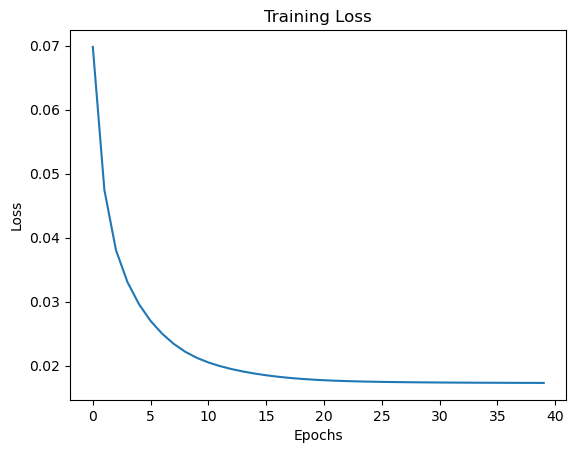

Final Loss for F1 with h=32: 0.0173


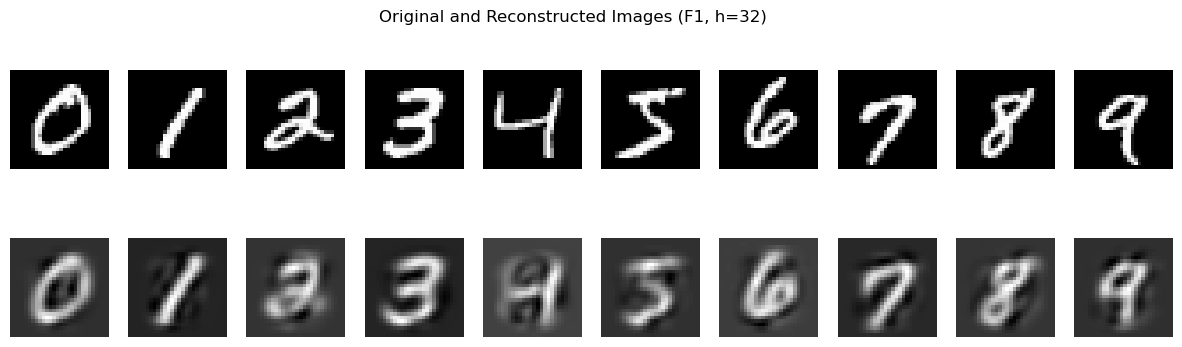

Epoch [5/40], Loss: 0.0165
Epoch [10/40], Loss: 0.0114
Epoch [15/40], Loss: 0.0101
Epoch [20/40], Loss: 0.0096
Epoch [25/40], Loss: 0.0095
Epoch [30/40], Loss: 0.0094
Epoch [35/40], Loss: 0.0094
Epoch [40/40], Loss: 0.0093


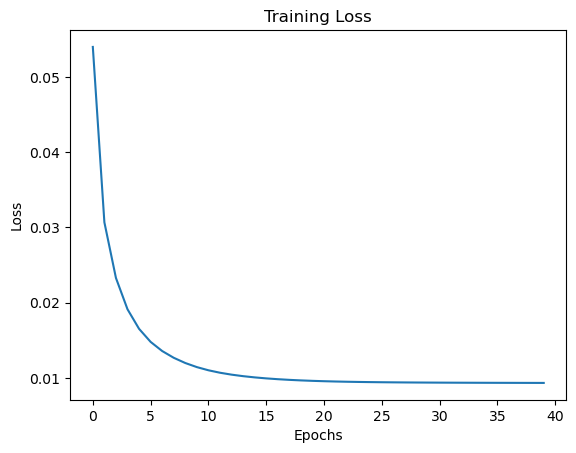

Final Loss for F1 with h=64: 0.0093


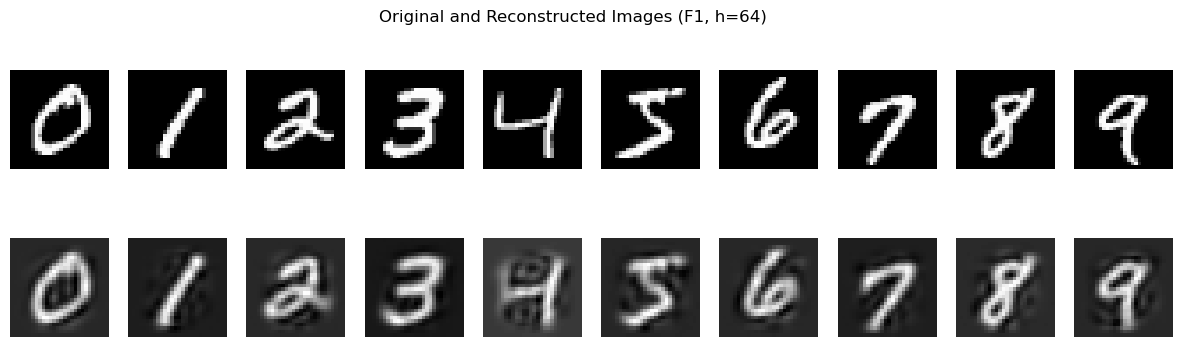

Epoch [5/40], Loss: 0.0081
Epoch [10/40], Loss: 0.0053
Epoch [15/40], Loss: 0.0047
Epoch [20/40], Loss: 0.0045
Epoch [25/40], Loss: 0.0044
Epoch [30/40], Loss: 0.0044
Epoch [35/40], Loss: 0.0043
Epoch [40/40], Loss: 0.0043


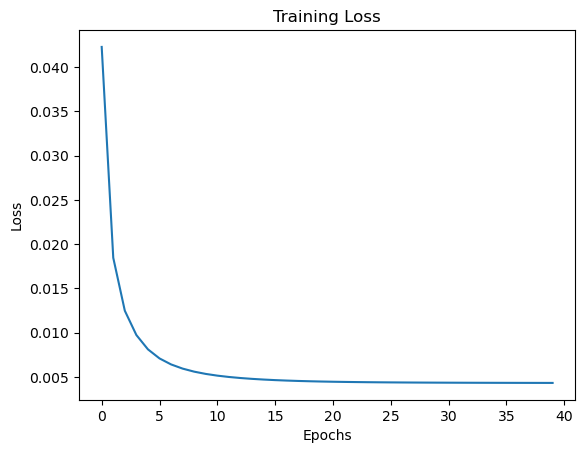

Final Loss for F1 with h=128: 0.0043


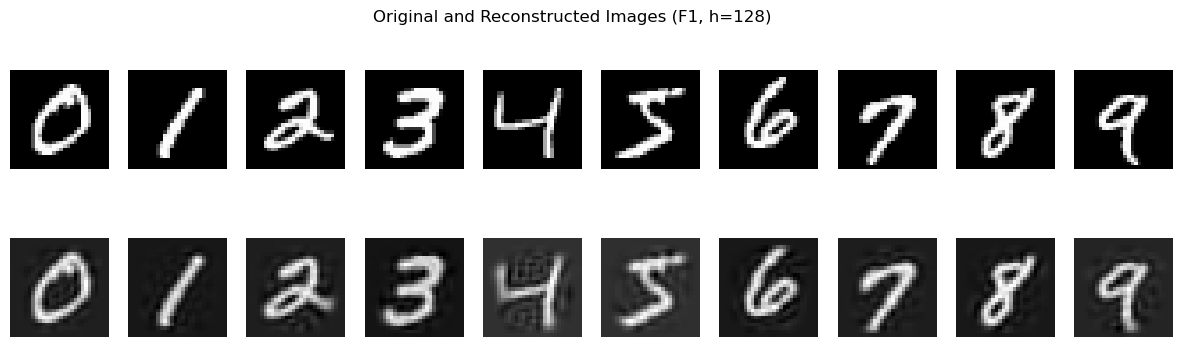

Epoch [5/40], Loss: 0.0298
Epoch [10/40], Loss: 0.0246
Epoch [15/40], Loss: 0.0227
Epoch [20/40], Loss: 0.0216
Epoch [25/40], Loss: 0.0210
Epoch [30/40], Loss: 0.0205
Epoch [35/40], Loss: 0.0202
Epoch [40/40], Loss: 0.0199


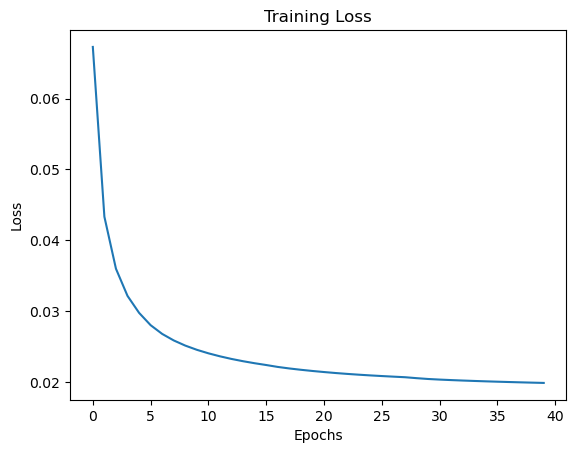

Final Loss for F2 with h=32: 0.0199


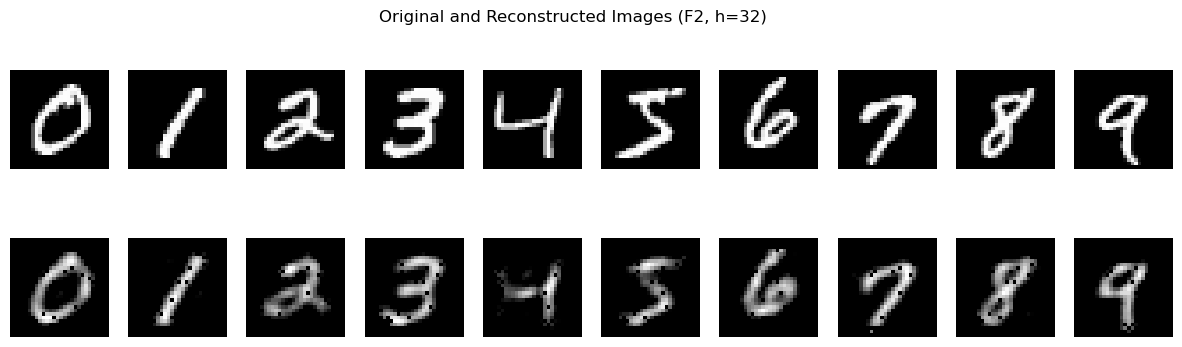

Epoch [5/40], Loss: 0.0197
Epoch [10/40], Loss: 0.0165
Epoch [15/40], Loss: 0.0153
Epoch [20/40], Loss: 0.0148
Epoch [25/40], Loss: 0.0144
Epoch [30/40], Loss: 0.0141
Epoch [35/40], Loss: 0.0139
Epoch [40/40], Loss: 0.0138


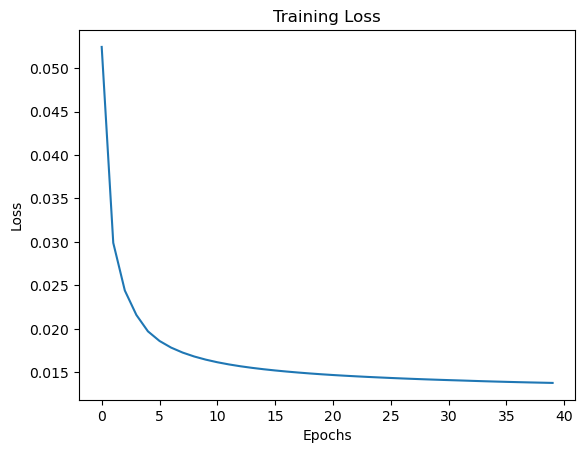

Final Loss for F2 with h=64: 0.0138


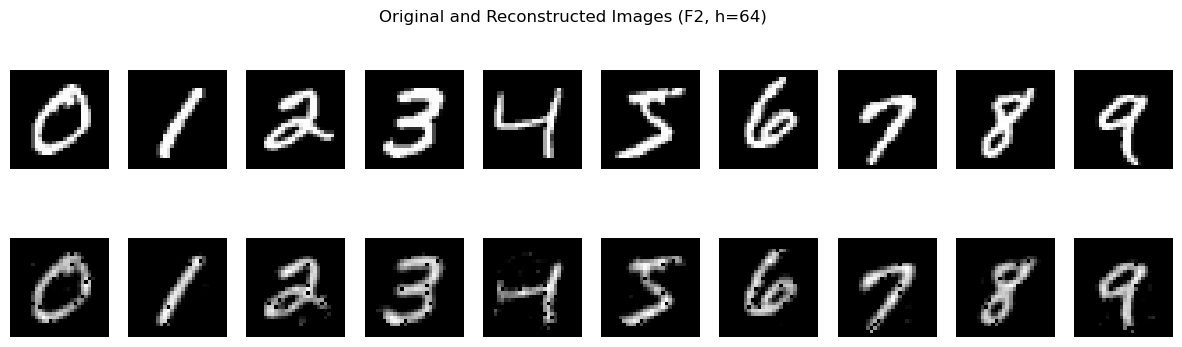

Epoch [5/40], Loss: 0.0100
Epoch [10/40], Loss: 0.0078
Epoch [15/40], Loss: 0.0071
Epoch [20/40], Loss: 0.0068
Epoch [25/40], Loss: 0.0066
Epoch [30/40], Loss: 0.0065
Epoch [35/40], Loss: 0.0064
Epoch [40/40], Loss: 0.0063


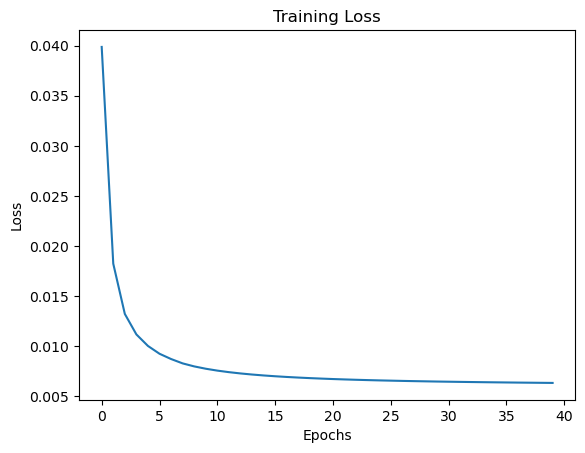

Final Loss for F2 with h=128: 0.0063


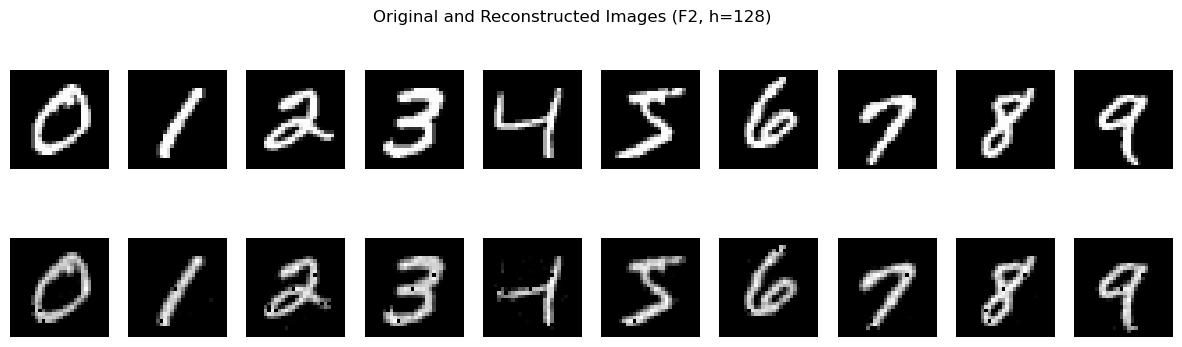

Test error for F1 with h=128: 0.0042
Test error for F2 with h=128: 0.0063
147.07718801498413


In [4]:
start = time()
if __name__ == "__main__":
    main()
time_used = time() - start
print(time_used)

**1.4** Image Classification on CIFAR-10

In this problem we will explore different deep learning architectures for image classification on the CIFAR-10 dataset. Make sure that you are familiar with tensors, two-dimensional convolutions (```nn.Conv2d```) and fully-connected layers (```nn.Linear```), ReLU non-linearities (```F.relu```), pooling (```nn.MaxPool2d```), and tensor reshaping (```view```).

A few preliminaries:

- Each network $f$ maps an image $x^\text{in} \in \mathbb{R}^{32 \times 32 \times 3}$ (3 channels for RGB) to an output $f(x^\text{in}) = x^\text{out} \in \mathbb{R}^{10}$. The class label is predicted as $\arg\max_{i=0,1,\dots,9} x_{i}^\text{out}$. An error occurs if the predicted label differs from the true label for a given image. 
- The network is trained via multiclass cross-entropy loss. 
- Create a validation dataset by appropriately partitioning the train dataset. *Hint*: look at the documentation for ```torch.utils.data.random_split```. Make sure to tune hyperparameters like network architecture and step size on the validation dataset. Do **NOT** validate your hyperparameters on the test dataset.
- At the end of each epoch (one pass over the training data), compute and print the training and validation classification accuracy.
- While one would usually train a network for hundreds of epochs to reach convergence and maximize accuracy, this can be prohibitively time-consuming, so feel free to train for just a dozen or so epochs. 

For parts (a) and (b), apply a hyperparameter tuning method (e.g. random search, grid search, etc.) using the validation set, report the hyperparameter configurations you evaluated and the best set of hyperparameters from this set, and plot the training and validation classification accuracy as a function of epochs. Produce a separate line or plot for each hyperparameter configuration evaluated (top 5 configurations is sufficient to keep the plots clean). Finally, evaluate your best set of hyperparameters on the test data and report the test accuracy. 


**Note 1:** Please refer to the notebook with starter code for this problem and the notebook provided with lecture 19. That notebook provides a complete end-to-end example of loading data, training a model using a simple network with a fully-connected output and no hidden layers (logistic regression), and performing evaluation using canonical Pytorch. We recommend using this as a template for your implementations of the models below.[

**Note 2:** If you are attempting this problem and do not have access to GPU we highly recommend using Google Colab. The provided notebook includes instructions on how to use GPU in Google Colab.


Here are the network architectures you will construct and compare. 

**a.** [18 points] **Fully-connected output, 1 fully-connected hidden layer:** this network has one hidden layer denoted as $x^\mathrm{hidden} \in \mathbb{R}^{M}$ where $M$ will be a hyperparameter you choose ($M$ could be in the hundreds). The nonlinearity applied to the hidden layer will be the ```relu``` ($\mathrm{relu}(x) = \max\{0,x\}$. This network can be written as
  \begin{align*}
    x^{out} &= W_2 \mathrm{relu}(W_1 \mathrm{vect}(x^{in}) +b_1) + b_2
  \end{align*}
  where $W_1 \in \mathbb{R}^{M \times 3072}$, $b_1 \in \mathbb{R}^M$, $W_2 \in \mathbb{R}^{10 \times M}$, $b_2 \in \mathbb{R}^{10}$, and $\mathrm{vect}(\cdot)$ flattens a tensor into a vector.
  Tune the different hyperparameters and train for a sufficient number of epochs to achieve a *validation accuracy* of at least 50\%. Provide the hyperparameter configuration used to achieve this performance.
  
**b.** [18 points] **Convolutional layer with max-pool and fully-connected output:** for a convolutional layer $W_1$ with filters of size $k \times k \times 3$, and $M$ filters (reasonable choices are $M=100$, $k=5$), we have that $\mathrm{Conv2d}(x^\text{in}, W_1) \in \mathbb{R}^{(33-k) \times (33-k) \times M}$.
  
- Each convolution will have its own offset applied to each of the output pixels of the convolution; we denote this as $\mathrm{Conv2d}(x^\text{in}, W) + b_1$ where $b_1$ is parameterized in $\mathbb{R}^M$. Apply a ```relu``` activation to the result of the convolutional layer. 

- Next, use a max-pool of size $N \times N$ (a reasonable choice is $N=14$ to pool to $2 \times 2$ with $k=5$) we have that $\textrm{MaxPool}( \mathrm{relu}( \mathrm{Conv2d}(x^\text{in}, W_1)+b_1)) \in \mathbb{R}^{\lfloor\frac{33-k}{N}\rfloor \times \lfloor\frac{33-k}{N}\rfloor \times M}$.

- We will then apply a fully-connected layer to the output to get a final network given as

\begin{align*}
 x^{output} = W_2 \mathrm{vect}(\textrm{MaxPool}( \mathrm{relu}( \mathrm{Conv2d}(x^\text{input}, W_1)+b_1))) + b_2
\end{align*}
          
where $W_2 \in \mathbb{R}^{10 \times M (\lfloor\frac{33-k}{N}\rfloor)^2}$, $b_2 \in \mathbb{R}^{10}$.
  
The parameters $M,k,N$ (in addition to the step size and momentum) are all hyperparameters, but you can choose a reasonable value. Tune the different hyperparameters (number of convolutional filters, filter sizes, dimensionality of the fully-connected layers, step size, etc.) and train for a sufficient number of epochs to achieve a \emph{validation accuracy} of at least 65\%. Provide the hyperparameter configuration used to achieve this performance.
Make sure to save the best model during the hyperparameter tuning so that you can evaluate test accuracy without retraining.
  
The number of hyperparameters to tune, combined with the slow training times, will hopefully give you a taste of how difficult it is to construct networks with good generalization performance. State-of-the-art networks can have dozens of layers, each with their own hyperparameters to tune. Additional hyperparameters you are welcome to play with if you are so inclined, include: changing the activation function, replace max-pool with average-pool, adding more convolutional or fully connected layers, and experimenting with batch normalization or dropout.

**What to Submit:**

- **Parts a-b:** Plot of training and validation accuracy for each TOP 5 hyperparameter configurations evaluated. (10 lines total). If it took less than 5 hyperparameter configurations to pass performance threshold plot all hyperparameter configurations evaluated. List of the hyperparameter values you searched over, and your search method (random, grid, etc.).
- **Parts a-b:** Values of best performing hyperparameters, and accuracy of best models on test data.
- Code

In [2]:
import torch
print(torch.backends.mps.is_available())  # Should return True
print(torch.backends.mps.is_built())     # Should return True

True
True


In [12]:
# mps
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print(f"Using device: {device}")

# device = torch.device("cpu")
# print(f"Using device: {device}")

Using device: cpu


In [ ]:
def fc_network(M: int) -> nn.Module:
    """fc_network, It should implement a neural network with a single hidden layer, e.g., 
    Linear(ReLU(Linear(x)))
    
    Note:
        - While bias is not mentioned explicitly in equations above, it should be used.
            It is used by default in nn.Linear which you can use in this problem.

    Args:
        M (int): Dimensionality of the encoding (the hidden layer).

    Returns:
        nn.Module: An initialized fully connected model.
    """
    fc = nn.Sequential(
        nn.Flatten(),  # Flatten the input
        nn.Linear(32*32*3, M), 
        nn.ReLU(),
        nn.Linear(M, 10)
    )
    return fc


def conv_network(k: int, m: int, n: int) -> nn.Module:
    """Model conv_net, it should performs an operation Linear(flatten(MaxPool(relu(Conv2d(x))))) as written in spec.

    Note:
        - While bias is not mentioned explicitly in equations above, it should be used.
            It is used by default in nn.Linear which you can use in this problem.

    Args:
        k (int): size of a convolutional filter (5)
        m (int): number of filters (100)
        n (int): pool size  (14)

    Returns:
        nn.Module: An initialized convolutional network.
    """
    conv = nn.Sequential(
        # nn.Conv2d(3, m, kernel_size=k, padding=k//2),  # Convolutional layer, padding to keep the same size
        nn.Conv2d(3, m, kernel_size=k), # no padding
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=n),  # Max pooling layer
        nn.Flatten(),  # Flatten the output
        # nn.Linear(m * (32 // n) * (32 // n), 10)
        nn.Linear(m * ((33-k) // n) * ((33-k) // n), 10) # 不太明白怎么算 Q_Q
    )
    return conv

    
def train_nn(
    model: nn.Module, optimizer: Adam, train_loader: DataLoader, epochs: int = 40, device: str = "mps"
) -> float:
    """
    Train a model until convergence on train set, and return a mean squared error loss on the last epoch.

    Args:
        model (Module): Model to train. Either F1, or F2 in this problem.
        optimizer (Adam): Optimizer that will adjust parameters of the model.
            Hint: You can try using learning rate of 5e-5.
        train_loader (DataLoader): DataLoader with training data.
            You can iterate over it like a list, and it will produce x
            where x is FloatTensor of shape (n, d).

    Note:
        - Unfortunately due to how DataLoader class is implemented in PyTorch
            "for x_batch in train_loader:" will not work. Use:
            "for (x_batch,) in train_loader:" instead.

    Returns:
        float: Final training error/loss
    """
    criterion = nn.CrossEntropyLoss()
    Loss = []
    Accuracy = []
    # model.to(device) 
    

    for epoch in range(epochs):
        model.train()  # Set the model to training mode

        # debug device
        print(f"Model is on device: {next(model.parameters()).device}")

        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device) 

            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()

            _, predicted_labels = torch.max(output, 1)  # Get predicted labels
            correct_predictions += (predicted_labels == target).sum().item()
            total_samples += target.size(0)

            loss.backward()
            optimizer.step()
        epoch_avg_loss = total_loss / len(train_loader)
        Loss.append(epoch_avg_loss)
        epoch_accuracy = correct_predictions / total_samples
        Accuracy.append(epoch_accuracy)
        if (epoch+1) % 5 == 0:  # Print every 5 epochs
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_avg_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
        evaluate(model, )
    
    # Plot the loss
    # plt.plot(Loss)
    # plt.xlabel("Epochs")
    # plt.ylabel("Loss")
    # plt.title("Training Loss")
    # plt.show()
    return Loss[-1], Accuracy[-1]  # Return the final loss and accuracy 


def evaluate(model: nn.Module, val_loader: DataLoader, device: str = "mps") -> float:
    """Evaluates a model on a provided dataset.
    It should return an average loss of that dataset.

    Args:
        model (Module): TRAINED Model to evaluate. Either F1, or F2 in this problem.
        loader (DataLoader): DataLoader with some data.
            You can iterate over it like a list, and it will produce x
            where x is FloatTensor of shape (n, d).

    Returns:
        float: Mean Squared Error on the provided dataset.
    """
    model.to(device)  # Move the model to the specified device
    model.eval()  # Set the model to evaluation mode
    val_loss = []
    val_accuracy = []
    total_val_loss = 0
    val_correct = 0
    val_samples = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():  # Disable gradient calculation
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_val_loss += loss.item()

            _, predicted_labels = torch.max(output, 1)  # Get predicted labels
            val_correct += (predicted_labels == target).sum().item()
            val_samples += target.size(0)
        
    average_val_loss = total_val_loss / len(val_loader)
    val_loss.append(average_val_loss)
    epoch_val_accuracy = val_correct / val_samples
    val_accuracy.append(epoch_val_accuracy)
    return epoch_val_accuracy


def train_and_val(
        model: nn.Module,
        optimizer: Adam,
        train_loader,
        val_loader,
        epochs: int = 40,
        device: str = "cpu",
) -> Tuple[float, float, float, float]:
    criterion = nn.CrossEntropyLoss()
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    # model.to(device) 
    

    for epoch in range(epochs):
        model.train()  # Set the model to training mode

        # debug device
        # print(f"Model is on device: {next(model.parameters()).device}")

        total_train_loss = 0
        train_correct = 0
        train_samples = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device) 

            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            total_train_loss += loss.item()

            _, predicted_labels = torch.max(output, 1)  # Get predicted labels
            train_correct += (predicted_labels == target).sum().item()
            train_samples += target.size(0)

            loss.backward()
            optimizer.step()

        epoch_avg_loss = total_train_loss / len(train_loader)
        train_loss.append(epoch_avg_loss)
        epoch_accuracy = train_correct / train_samples
        train_accuracy.append(epoch_accuracy)

        
        # eval for this epoch
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        val_correct = 0
        val_samples = 0
        criterion = nn.CrossEntropyLoss()
        with torch.no_grad():  # Disable gradient calculation
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                total_val_loss += loss.item()

                _, predicted_labels = torch.max(output, 1)  # Get predicted labels
                val_correct += (predicted_labels == target).sum().item()
                val_samples += target.size(0)
        
        average_val_loss = total_val_loss / len(val_loader)
        val_loss.append(average_val_loss)
        epoch_val_accuracy = val_correct / val_samples
        val_accuracy.append(epoch_val_accuracy)

        if (epoch+1) % 10 == 0:  # Print every 5 epochs
            print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_avg_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

    # Plot the training and val accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_accuracy, label="Training Accuracy", marker='o')
    plt.plot(range(1, epochs + 1), val_accuracy, label="Validation Accuracy", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_loss, train_accuracy, val_loss, val_accuracy
    
    

In [ ]:
def grid_search_nn(
    model_class: str, train_loader: DataLoader, val_loader: DataLoader, epochs: int, device: str = "mps"
) -> Tuple[float, float, float, float]:
    """Grid search over hyperparameters of a model.

    Args:
        model_class (str): Model class to use. Either "fc" or "conv".
        train_loader (DataLoader): DataLoader with training data.
        test_loader (DataLoader): DataLoader with testing data.
        epochs
        device

    Returns:
        Tuple[float, float, float, float]: Tuple of 4 floats representing:
            1. Train error/loss on the best model.
            2. Train accuracy on the best model.
            3. Test loss on the best model
            4. Test accuracy on the best model
    """
    # Define hyperparameter grid
    if model_class == "fc":
        hyperparams = {
            "M": [100, 110, 120, 130],
            "lr": [5e-5, 1e-4]
        }
    elif model_class == "conv":
        hyperparams = {
            "k": [5],
            "m": [100, 120],
            "n": [2, 4, 7],
            "lr": [5e-5, 1e-4],
        }
    else:
        raise ValueError("Invalid model class. Choose either 'fc' or 'conv'.")

    # Initialize variables to track best performance
    best_train_loss = float("inf")
    best_val_loss = float("inf")
    best_train_accuracy = float(0)
    best_val_accuracy = float(0)
    best_model = None

    # Perform grid search
    for params in itertools.product(*hyperparams.values()):
        param_dict = dict(zip(hyperparams.keys(), params))
        
        if model_class == "fc":
            model = fc_network(param_dict["M"])
            model.to(device)  # Move the model to the specified device
        elif model_class == "conv":
            model = conv_network(param_dict["k"], param_dict["m"], param_dict["n"])
            model.to(device)  # Move the model to the specified device
        
        # Debug: Check if the model is on the GPU
        print(f"Model is on device: {next(model.parameters()).device}")

        optimizer = Adam(model.parameters(), lr=param_dict["lr"])
        
        # Train the model
        # train_loss, train_acc = train_nn(model, optimizer, train_loader, epochs=40, device=device)
        
        # Evaluate the model on the test set
        # val_loss = evaluate(model, val_loader, device=device)

        train_loss, train_accuracy, val_loss, val_accuracy = train_and_val(model, optimizer, train_loader, val_loader, epochs, device)
        # print(f"val_accuracy: {val_accuracy}, type: {type(val_accuracy)}")
        # print(f"val_accuracy: {val_accuracy[-1]}, type: {type(val_accuracy[-1])}")
        print(f"Current params: {param_dict}")

        # Update best performance if current model is better
        # if train_loss < best_train_loss:
        #     best_train_loss = train_loss
        #     best_test_loss = val_loss
        #     best_model = model
        # print(f"best_val_accuracy: {best_val_accuracy}, type: {type(best_val_accuracy)}")
        if val_accuracy[-1] > best_val_accuracy:
            # Update bests
            best_train_loss = train_loss[-1]
            best_val_loss = val_loss[-1]
            best_train_accuracy = train_accuracy[-1]
            best_val_accuracy = val_accuracy[-1]

            best_model = model
            best_params = param_dict
    print(f"Best Model Parameters: {best_params}")
    print(f"Best Train Accuracy: {best_train_accuracy:.4f}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.4f}") 
    # Save the best model
    torch.save(best_model.state_dict(), f"best_nn_model_{model_class}.pth") 
    return best_train_loss, best_train_accuracy, best_val_loss, best_val_accuracy

In [42]:
training_data = datasets.CIFAR10(
    root=".",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root=".",
    train=False,
    download=True,
    transform=ToTensor(),
)
batch_size = 64

# Split training data into training and validation sets.
train_size = int(0.9 * len(training_data))  # 90% for training
val_size = len(training_data) - train_size  # 10% for validation
train_set, val_set = random_split(training_data, [train_size, val_size])

# Create data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True) # num_workers=4
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


Model is on device: cpu
Epoch [10/50], Train Loss: 1.6457, Train Accuracy: 0.4295, Val Loss: 1.6753, Val Accuracy: 0.4126
Epoch [20/50], Train Loss: 1.5257, Train Accuracy: 0.4722, Val Loss: 1.5832, Val Accuracy: 0.4492
Epoch [30/50], Train Loss: 1.4546, Train Accuracy: 0.4948, Val Loss: 1.5239, Val Accuracy: 0.4634
Epoch [40/50], Train Loss: 1.4060, Train Accuracy: 0.5125, Val Loss: 1.4957, Val Accuracy: 0.4756
Epoch [50/50], Train Loss: 1.3631, Train Accuracy: 0.5263, Val Loss: 1.4722, Val Accuracy: 0.4902


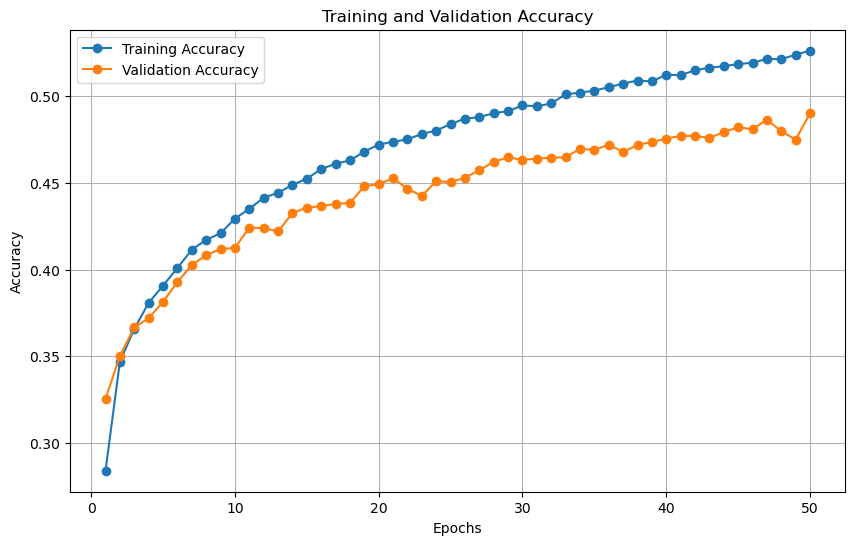

Current params: {'M': 100, 'lr': 5e-05}
Model is on device: cpu
Epoch [10/50], Train Loss: 1.5923, Train Accuracy: 0.4434, Val Loss: 1.6383, Val Accuracy: 0.4254
Epoch [20/50], Train Loss: 1.4714, Train Accuracy: 0.4871, Val Loss: 1.5530, Val Accuracy: 0.4522
Epoch [30/50], Train Loss: 1.3952, Train Accuracy: 0.5123, Val Loss: 1.4958, Val Accuracy: 0.4808
Epoch [40/50], Train Loss: 1.3397, Train Accuracy: 0.5316, Val Loss: 1.4805, Val Accuracy: 0.4752
Epoch [50/50], Train Loss: 1.2992, Train Accuracy: 0.5458, Val Loss: 1.4409, Val Accuracy: 0.4954


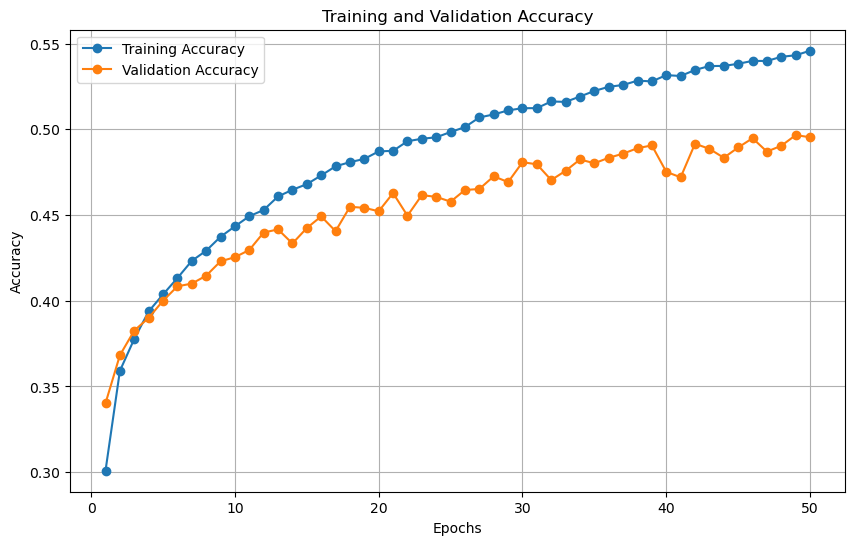

Current params: {'M': 100, 'lr': 0.0001}
Model is on device: cpu
Epoch [10/50], Train Loss: 1.6290, Train Accuracy: 0.4344, Val Loss: 1.6644, Val Accuracy: 0.4222
Epoch [20/50], Train Loss: 1.5168, Train Accuracy: 0.4757, Val Loss: 1.5931, Val Accuracy: 0.4416
Epoch [30/50], Train Loss: 1.4501, Train Accuracy: 0.4976, Val Loss: 1.5287, Val Accuracy: 0.4618
Epoch [40/50], Train Loss: 1.3958, Train Accuracy: 0.5168, Val Loss: 1.4880, Val Accuracy: 0.4820
Epoch [50/50], Train Loss: 1.3505, Train Accuracy: 0.5320, Val Loss: 1.4616, Val Accuracy: 0.4906


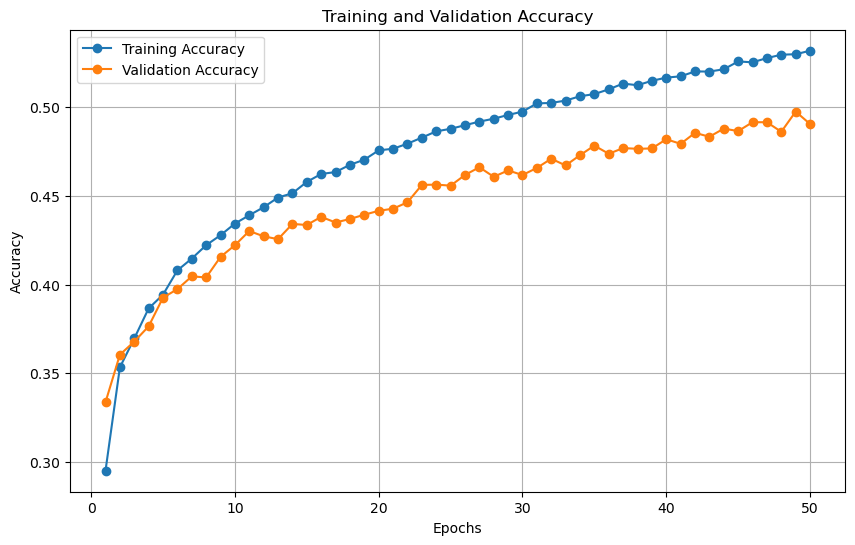

Current params: {'M': 110, 'lr': 5e-05}
Model is on device: cpu
Epoch [10/50], Train Loss: 1.5718, Train Accuracy: 0.4549, Val Loss: 1.6087, Val Accuracy: 0.4390
Epoch [20/50], Train Loss: 1.4456, Train Accuracy: 0.4981, Val Loss: 1.5371, Val Accuracy: 0.4662
Epoch [30/50], Train Loss: 1.3668, Train Accuracy: 0.5255, Val Loss: 1.4800, Val Accuracy: 0.4816
Epoch [40/50], Train Loss: 1.3069, Train Accuracy: 0.5470, Val Loss: 1.4556, Val Accuracy: 0.4920
Epoch [50/50], Train Loss: 1.2604, Train Accuracy: 0.5615, Val Loss: 1.4511, Val Accuracy: 0.4966


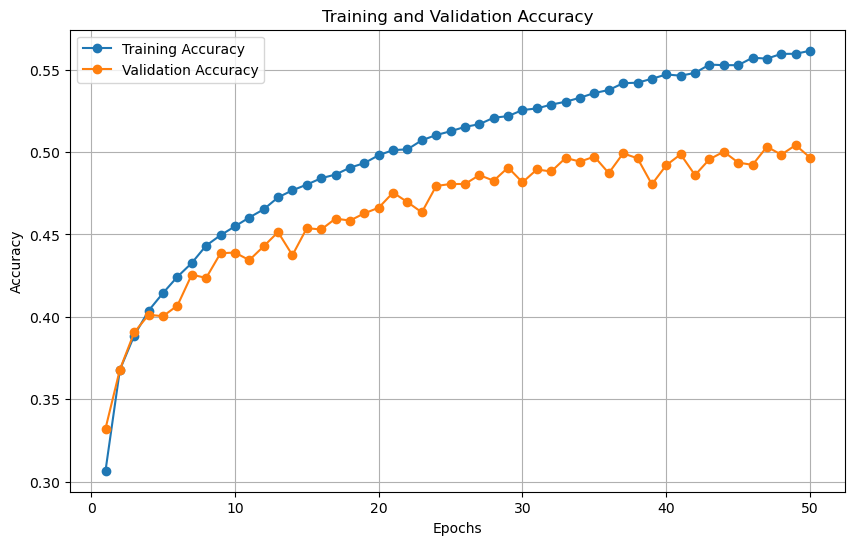

Current params: {'M': 110, 'lr': 0.0001}
Model is on device: cpu
Epoch [10/50], Train Loss: 1.6243, Train Accuracy: 0.4370, Val Loss: 1.6636, Val Accuracy: 0.4230
Epoch [20/50], Train Loss: 1.5060, Train Accuracy: 0.4786, Val Loss: 1.5735, Val Accuracy: 0.4480
Epoch [30/50], Train Loss: 1.4325, Train Accuracy: 0.5032, Val Loss: 1.5184, Val Accuracy: 0.4682
Epoch [40/50], Train Loss: 1.3744, Train Accuracy: 0.5221, Val Loss: 1.4815, Val Accuracy: 0.4802
Epoch [50/50], Train Loss: 1.3304, Train Accuracy: 0.5409, Val Loss: 1.4602, Val Accuracy: 0.4918


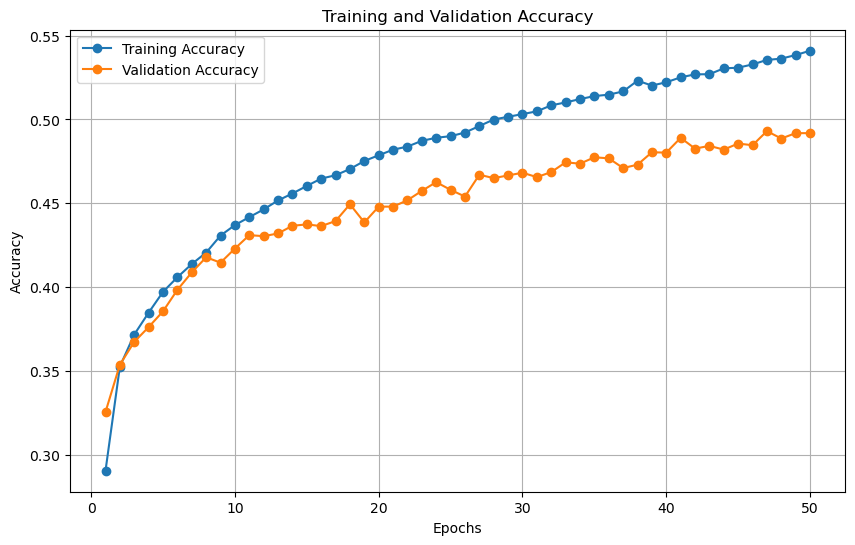

Current params: {'M': 120, 'lr': 5e-05}
Model is on device: cpu
Epoch [10/50], Train Loss: 1.5488, Train Accuracy: 0.4616, Val Loss: 1.5986, Val Accuracy: 0.4364
Epoch [20/50], Train Loss: 1.4242, Train Accuracy: 0.5057, Val Loss: 1.5174, Val Accuracy: 0.4706
Epoch [30/50], Train Loss: 1.3430, Train Accuracy: 0.5312, Val Loss: 1.4525, Val Accuracy: 0.4852
Epoch [40/50], Train Loss: 1.2793, Train Accuracy: 0.5530, Val Loss: 1.4252, Val Accuracy: 0.5028
Epoch [50/50], Train Loss: 1.2309, Train Accuracy: 0.5711, Val Loss: 1.4120, Val Accuracy: 0.5066


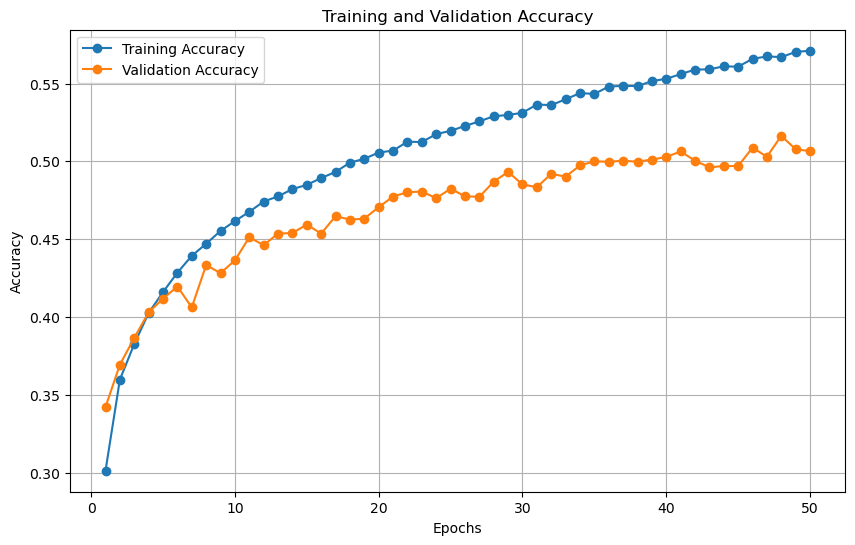

Current params: {'M': 120, 'lr': 0.0001}
Model is on device: cpu
Epoch [10/50], Train Loss: 1.6421, Train Accuracy: 0.4306, Val Loss: 1.6829, Val Accuracy: 0.4104
Epoch [20/50], Train Loss: 1.5225, Train Accuracy: 0.4737, Val Loss: 1.5851, Val Accuracy: 0.4514
Epoch [30/50], Train Loss: 1.4505, Train Accuracy: 0.4984, Val Loss: 1.5228, Val Accuracy: 0.4688
Epoch [40/50], Train Loss: 1.3934, Train Accuracy: 0.5184, Val Loss: 1.4870, Val Accuracy: 0.4836
Epoch [50/50], Train Loss: 1.3459, Train Accuracy: 0.5342, Val Loss: 1.4620, Val Accuracy: 0.4882


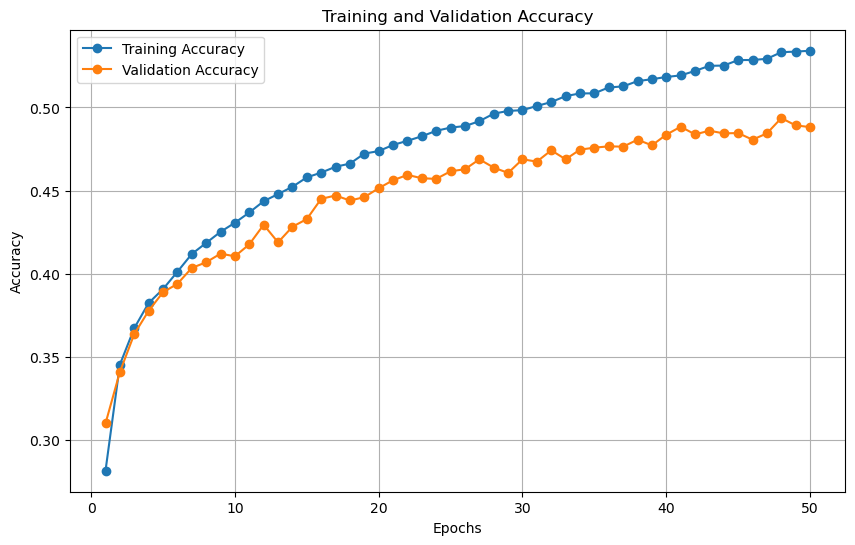

Current params: {'M': 130, 'lr': 5e-05}
Model is on device: cpu
Epoch [10/50], Train Loss: 1.5546, Train Accuracy: 0.4576, Val Loss: 1.6137, Val Accuracy: 0.4288
Epoch [20/50], Train Loss: 1.4319, Train Accuracy: 0.5025, Val Loss: 1.5012, Val Accuracy: 0.4690
Epoch [30/50], Train Loss: 1.3541, Train Accuracy: 0.5290, Val Loss: 1.4701, Val Accuracy: 0.4866
Epoch [40/50], Train Loss: 1.2984, Train Accuracy: 0.5483, Val Loss: 1.4392, Val Accuracy: 0.4946
Epoch [50/50], Train Loss: 1.2490, Train Accuracy: 0.5660, Val Loss: 1.4229, Val Accuracy: 0.5072


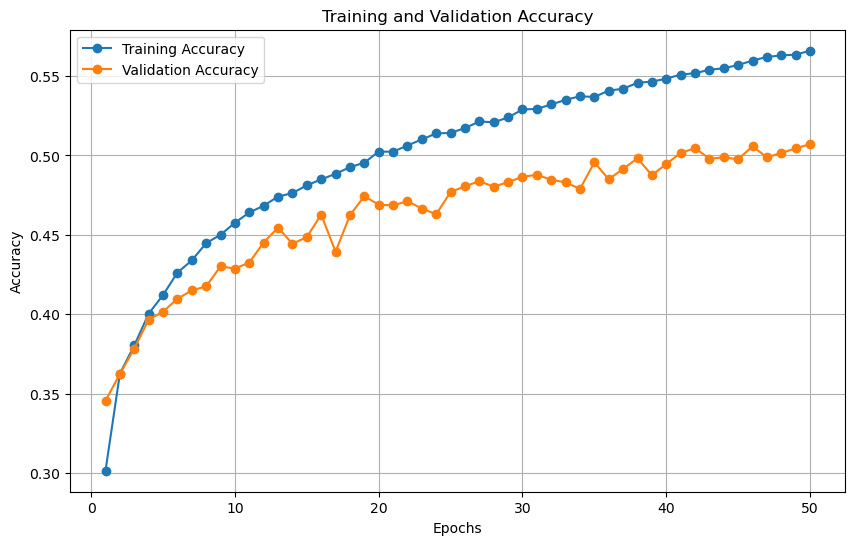

Current params: {'M': 130, 'lr': 0.0001}
Best Model Parameters: {'M': 130, 'lr': 0.0001}
Best Train Accuracy: 0.5660
Best Validation Accuracy: 0.5072


In [ ]:
# Perform grid search for fully connected network
# params used prints after each plot
best_train_loss, best_train_accuracy, best_val_loss, best_val_accuracy = grid_search_nn("fc", train_loader, val_loader, epochs = 50, device = device)

In [ ]:
# time for fc tuning: 12min and 30sec for 8 param combinations, 50 epochs each

In [ ]:
# Test best fc model
# Initialize with same architecture (params)
loaded_fc_model = fc_network(M=130)
loaded_fc_model.load_state_dict(torch.load("best_nn_model_fc.pth"))

test_accuracy = evaluate(loaded_fc_model, test_loader, device)
print(f"Best fc model test accuracy: {test_accuracy}")

Best fc model test accuracy: 0.5063


Model is on device: mps:0
Epoch [10/50], Train Loss: 1.2077, Train Accuracy: 0.5878, Val Loss: 1.2650, Val Accuracy: 0.5602
Epoch [20/50], Train Loss: 1.0597, Train Accuracy: 0.6423, Val Loss: 1.1505, Val Accuracy: 0.6052
Epoch [30/50], Train Loss: 0.9724, Train Accuracy: 0.6724, Val Loss: 1.1035, Val Accuracy: 0.6118
Epoch [40/50], Train Loss: 0.9092, Train Accuracy: 0.6950, Val Loss: 1.0685, Val Accuracy: 0.6274
Epoch [50/50], Train Loss: 0.8601, Train Accuracy: 0.7122, Val Loss: 1.0432, Val Accuracy: 0.6356


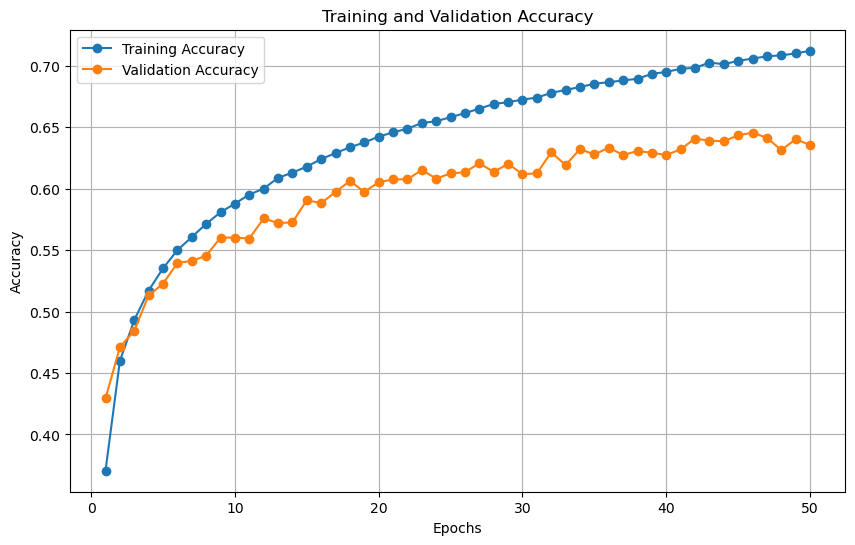

Current params: {'k': 5, 'm': 100, 'n': 2, 'lr': 5e-05}
Model is on device: mps:0
Epoch [10/50], Train Loss: 1.0869, Train Accuracy: 0.6310, Val Loss: 1.1645, Val Accuracy: 0.5988
Epoch [20/50], Train Loss: 0.9324, Train Accuracy: 0.6850, Val Loss: 1.0625, Val Accuracy: 0.6332
Epoch [30/50], Train Loss: 0.8422, Train Accuracy: 0.7185, Val Loss: 1.0379, Val Accuracy: 0.6488
Epoch [40/50], Train Loss: 0.7734, Train Accuracy: 0.7430, Val Loss: 1.0212, Val Accuracy: 0.6466
Epoch [50/50], Train Loss: 0.7173, Train Accuracy: 0.7629, Val Loss: 1.0049, Val Accuracy: 0.6520


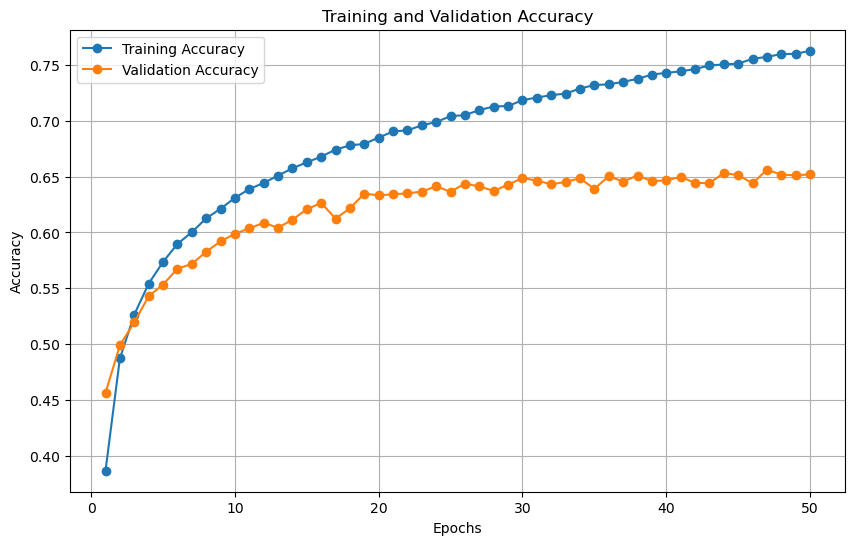

Current params: {'k': 5, 'm': 100, 'n': 2, 'lr': 0.0001}
Model is on device: mps:0
Epoch [10/50], Train Loss: 1.3273, Train Accuracy: 0.5449, Val Loss: 1.3603, Val Accuracy: 0.5252
Epoch [20/50], Train Loss: 1.1906, Train Accuracy: 0.5943, Val Loss: 1.2335, Val Accuracy: 0.5740
Epoch [30/50], Train Loss: 1.1053, Train Accuracy: 0.6245, Val Loss: 1.1564, Val Accuracy: 0.6024
Epoch [40/50], Train Loss: 1.0491, Train Accuracy: 0.6461, Val Loss: 1.1108, Val Accuracy: 0.6212
Epoch [50/50], Train Loss: 1.0061, Train Accuracy: 0.6599, Val Loss: 1.0928, Val Accuracy: 0.6254


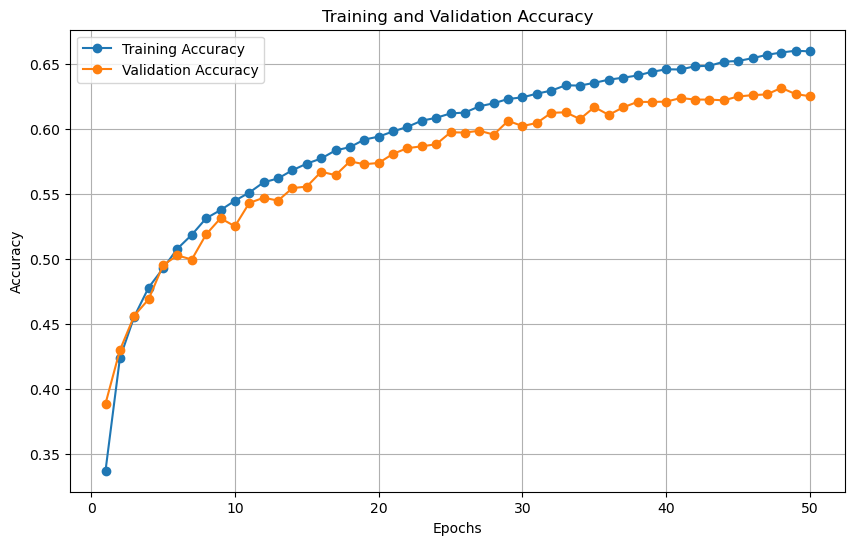

Current params: {'k': 5, 'm': 100, 'n': 4, 'lr': 5e-05}
Model is on device: mps:0
Epoch [10/50], Train Loss: 1.1801, Train Accuracy: 0.5965, Val Loss: 1.2147, Val Accuracy: 0.5820
Epoch [20/50], Train Loss: 1.0359, Train Accuracy: 0.6474, Val Loss: 1.1025, Val Accuracy: 0.6228
Epoch [30/50], Train Loss: 0.9629, Train Accuracy: 0.6748, Val Loss: 1.0453, Val Accuracy: 0.6392
Epoch [40/50], Train Loss: 0.9127, Train Accuracy: 0.6911, Val Loss: 1.0113, Val Accuracy: 0.6516
Epoch [50/50], Train Loss: 0.8729, Train Accuracy: 0.7073, Val Loss: 0.9896, Val Accuracy: 0.6588


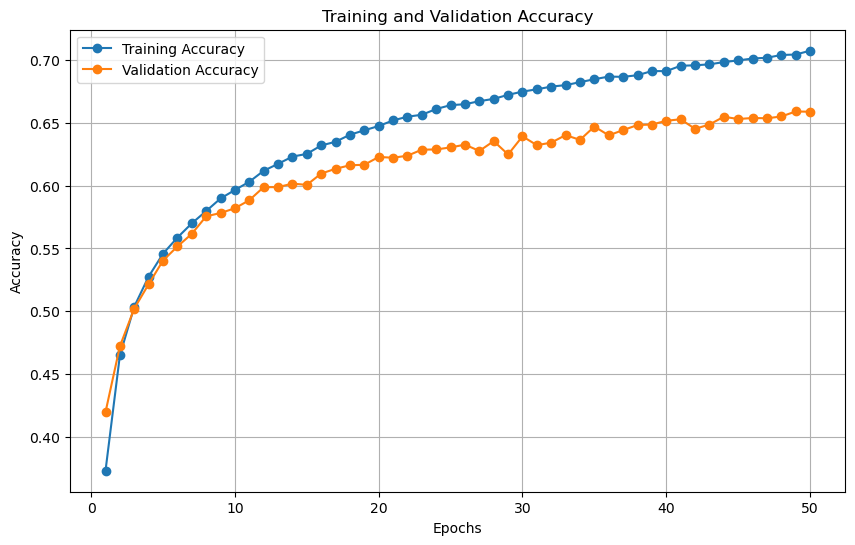

Current params: {'k': 5, 'm': 100, 'n': 4, 'lr': 0.0001}
Model is on device: mps:0
Epoch [10/50], Train Loss: 1.4508, Train Accuracy: 0.5017, Val Loss: 1.4705, Val Accuracy: 0.4930
Epoch [20/50], Train Loss: 1.3185, Train Accuracy: 0.5506, Val Loss: 1.3474, Val Accuracy: 0.5410
Epoch [30/50], Train Loss: 1.2329, Train Accuracy: 0.5815, Val Loss: 1.2689, Val Accuracy: 0.5708
Epoch [40/50], Train Loss: 1.1682, Train Accuracy: 0.6061, Val Loss: 1.2163, Val Accuracy: 0.5862
Epoch [50/50], Train Loss: 1.1198, Train Accuracy: 0.6222, Val Loss: 1.1707, Val Accuracy: 0.6034


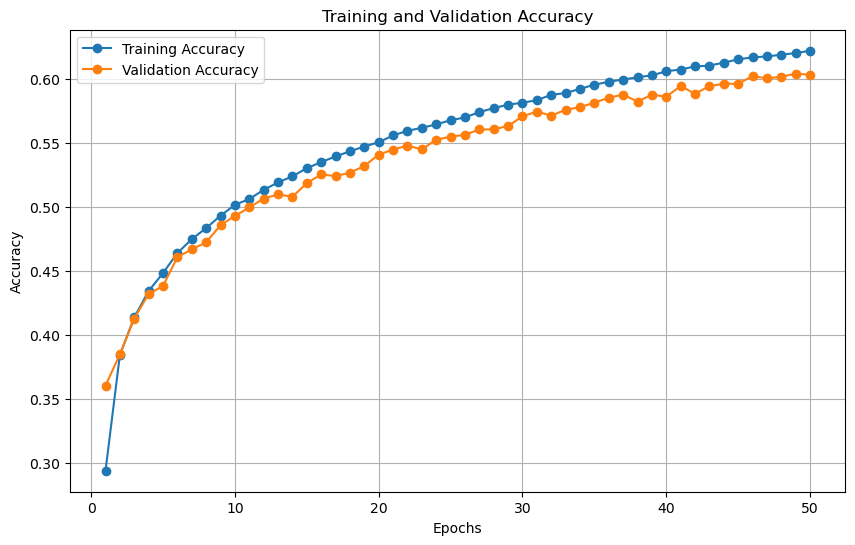

Current params: {'k': 5, 'm': 100, 'n': 7, 'lr': 5e-05}
Model is on device: mps:0
Epoch [10/50], Train Loss: 1.3123, Train Accuracy: 0.5520, Val Loss: 1.3346, Val Accuracy: 0.5400
Epoch [20/50], Train Loss: 1.1693, Train Accuracy: 0.6055, Val Loss: 1.2041, Val Accuracy: 0.5910
Epoch [30/50], Train Loss: 1.0884, Train Accuracy: 0.6315, Val Loss: 1.1403, Val Accuracy: 0.6092
Epoch [40/50], Train Loss: 1.0372, Train Accuracy: 0.6483, Val Loss: 1.1005, Val Accuracy: 0.6182
Epoch [50/50], Train Loss: 0.9999, Train Accuracy: 0.6596, Val Loss: 1.0716, Val Accuracy: 0.6296


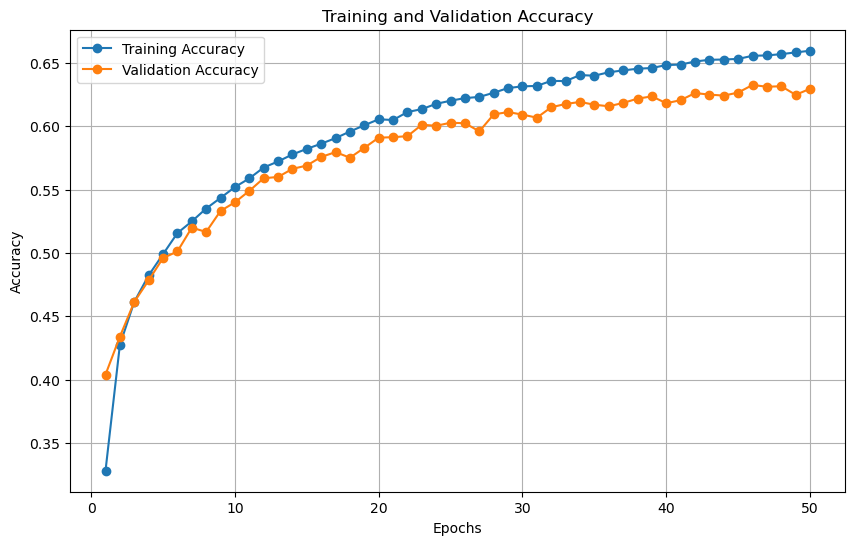

Current params: {'k': 5, 'm': 100, 'n': 7, 'lr': 0.0001}
Model is on device: mps:0
Epoch [10/50], Train Loss: 1.1709, Train Accuracy: 0.5988, Val Loss: 1.2381, Val Accuracy: 0.5676
Epoch [20/50], Train Loss: 1.0286, Train Accuracy: 0.6528, Val Loss: 1.1273, Val Accuracy: 0.6132
Epoch [30/50], Train Loss: 0.9429, Train Accuracy: 0.6819, Val Loss: 1.0702, Val Accuracy: 0.6240
Epoch [40/50], Train Loss: 0.8808, Train Accuracy: 0.7044, Val Loss: 1.0400, Val Accuracy: 0.6360
Epoch [50/50], Train Loss: 0.8312, Train Accuracy: 0.7210, Val Loss: 1.0122, Val Accuracy: 0.6488


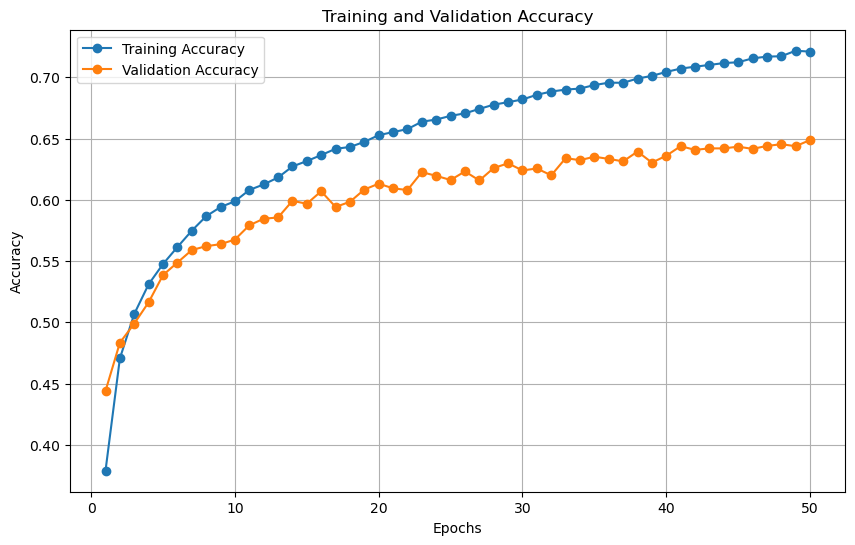

Current params: {'k': 5, 'm': 120, 'n': 2, 'lr': 5e-05}
Model is on device: mps:0
Epoch [10/50], Train Loss: 1.0481, Train Accuracy: 0.6448, Val Loss: 1.1378, Val Accuracy: 0.6064
Epoch [20/50], Train Loss: 0.8917, Train Accuracy: 0.7009, Val Loss: 1.0553, Val Accuracy: 0.6372
Epoch [30/50], Train Loss: 0.7957, Train Accuracy: 0.7328, Val Loss: 0.9981, Val Accuracy: 0.6534
Epoch [40/50], Train Loss: 0.7227, Train Accuracy: 0.7616, Val Loss: 1.0149, Val Accuracy: 0.6550
Epoch [50/50], Train Loss: 0.6631, Train Accuracy: 0.7839, Val Loss: 0.9788, Val Accuracy: 0.6638


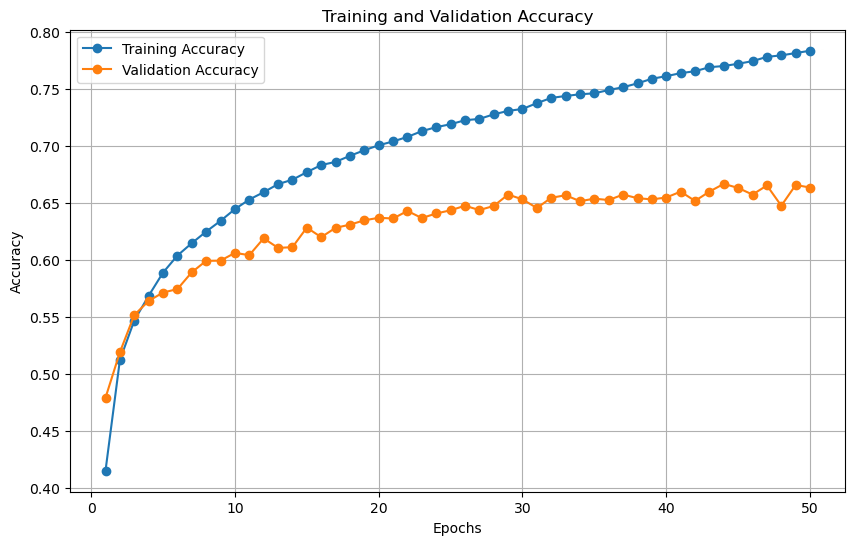

Current params: {'k': 5, 'm': 120, 'n': 2, 'lr': 0.0001}
Model is on device: mps:0
Epoch [10/50], Train Loss: 1.2873, Train Accuracy: 0.5610, Val Loss: 1.3112, Val Accuracy: 0.5540
Epoch [20/50], Train Loss: 1.1449, Train Accuracy: 0.6125, Val Loss: 1.1933, Val Accuracy: 0.5920
Epoch [30/50], Train Loss: 1.0657, Train Accuracy: 0.6415, Val Loss: 1.1221, Val Accuracy: 0.6172
Epoch [40/50], Train Loss: 1.0123, Train Accuracy: 0.6585, Val Loss: 1.0824, Val Accuracy: 0.6258
Epoch [50/50], Train Loss: 0.9731, Train Accuracy: 0.6723, Val Loss: 1.0571, Val Accuracy: 0.6322


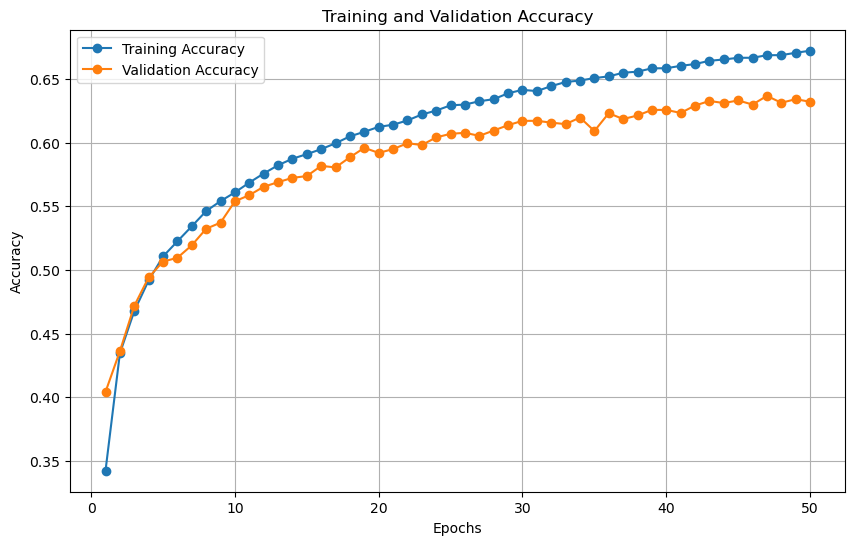

Current params: {'k': 5, 'm': 120, 'n': 4, 'lr': 5e-05}
Model is on device: mps:0
Epoch [10/50], Train Loss: 1.1549, Train Accuracy: 0.6056, Val Loss: 1.1853, Val Accuracy: 0.5984
Epoch [20/50], Train Loss: 1.0124, Train Accuracy: 0.6574, Val Loss: 1.0698, Val Accuracy: 0.6320
Epoch [30/50], Train Loss: 0.9390, Train Accuracy: 0.6816, Val Loss: 1.0261, Val Accuracy: 0.6522
Epoch [40/50], Train Loss: 0.8890, Train Accuracy: 0.7010, Val Loss: 1.0001, Val Accuracy: 0.6556
Epoch [50/50], Train Loss: 0.8504, Train Accuracy: 0.7151, Val Loss: 0.9737, Val Accuracy: 0.6684


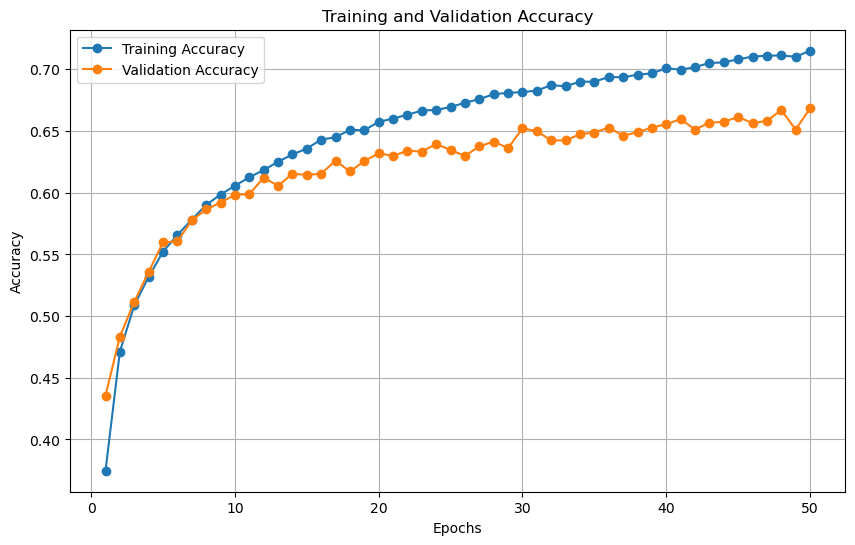

Current params: {'k': 5, 'm': 120, 'n': 4, 'lr': 0.0001}
Model is on device: mps:0
Epoch [10/50], Train Loss: 1.4025, Train Accuracy: 0.5199, Val Loss: 1.4219, Val Accuracy: 0.5084
Epoch [20/50], Train Loss: 1.2610, Train Accuracy: 0.5724, Val Loss: 1.2892, Val Accuracy: 0.5614
Epoch [30/50], Train Loss: 1.1763, Train Accuracy: 0.6040, Val Loss: 1.2126, Val Accuracy: 0.5862
Epoch [40/50], Train Loss: 1.1196, Train Accuracy: 0.6219, Val Loss: 1.1586, Val Accuracy: 0.6062
Epoch [50/50], Train Loss: 1.0800, Train Accuracy: 0.6345, Val Loss: 1.1254, Val Accuracy: 0.6112


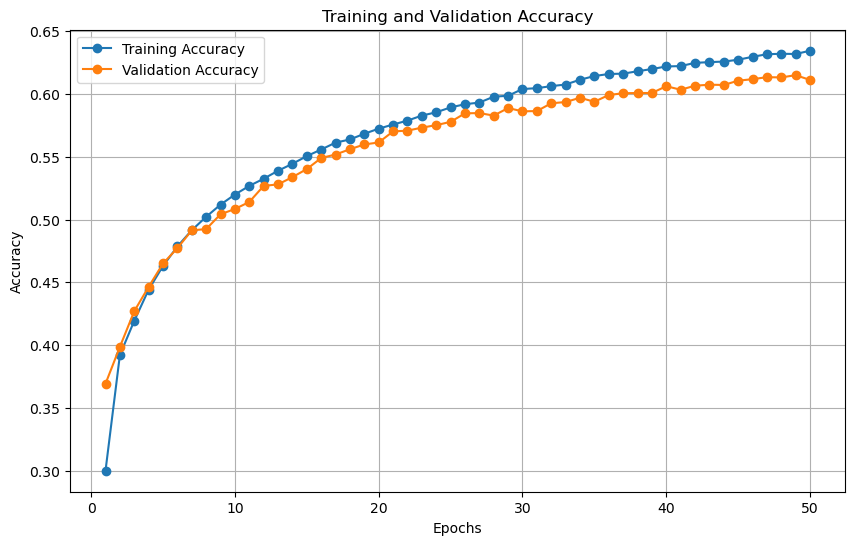

Current params: {'k': 5, 'm': 120, 'n': 7, 'lr': 5e-05}
Model is on device: mps:0
Epoch [10/50], Train Loss: 1.2965, Train Accuracy: 0.5578, Val Loss: 1.3238, Val Accuracy: 0.5440
Epoch [20/50], Train Loss: 1.1438, Train Accuracy: 0.6123, Val Loss: 1.1864, Val Accuracy: 0.5978
Epoch [30/50], Train Loss: 1.0622, Train Accuracy: 0.6419, Val Loss: 1.1181, Val Accuracy: 0.6184
Epoch [40/50], Train Loss: 1.0131, Train Accuracy: 0.6569, Val Loss: 1.0781, Val Accuracy: 0.6340
Epoch [50/50], Train Loss: 0.9761, Train Accuracy: 0.6687, Val Loss: 1.0408, Val Accuracy: 0.6460


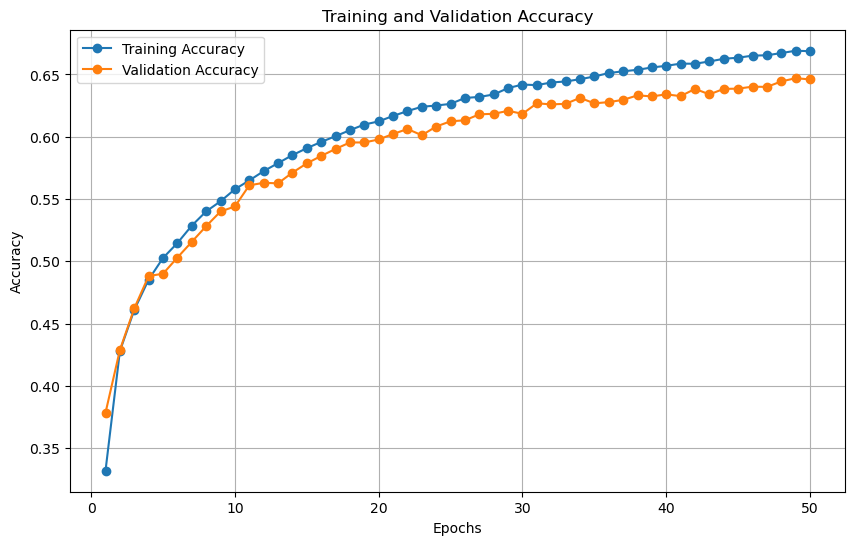

Current params: {'k': 5, 'm': 120, 'n': 7, 'lr': 0.0001}
Best Model Parameters: {'k': 5, 'm': 120, 'n': 4, 'lr': 0.0001}
Best Train Accuracy: 0.7151
Best Validation Accuracy: 0.6684


In [61]:
# Perform grid search for cnn network
# n=14 is much worse than 7, change hyperparams n=[7,14] -> [2,4,7]

# mps (GPU) is faster for cnn
device = torch.device("mps")
best_train_loss, best_train_accuracy, best_val_loss, best_val_accuracy = grid_search_nn("conv", train_loader, val_loader, epochs = 50, device = device)

In [ ]:
# cnn tune time: 57min 38sec for 12 hyperparam combinations, 50 epochs each

In [65]:
# Test best cnn model
# Initialize with same architecture (params)
loaded_conv_model = conv_network(k=5, m=120, n=4)
loaded_conv_model.load_state_dict(torch.load("best_nn_model_conv.pth"))

test_accuracy = evaluate(loaded_conv_model, test_loader, device)
print(f"Best conv model test accuracy: {test_accuracy}")


Best conv model test accuracy: 0.6698


In [ ]:
# def main():
#     training_data = datasets.CIFAR10(
#         root=".",
#         train=True,
#         download=True,
#         transform=ToTensor(),
#     )

#     # Download test data from open datasets.
#     test_data = datasets.CIFAR10(
#         root=".",
#         train=False,
#         download=True,
#         transform=ToTensor(),
#     )
#     batch_size = 64
    
#     # Split training data into training and validation sets.
#     train_size = int(0.9 * len(training_data))  # 90% for training
#     val_size = len(training_data) - train_size  # 10% for validation
#     train_set, val_set = random_split(training_data, [train_size, val_size])

#     # Create data loaders.
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
#     test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
   
#     raise NotImplementedError("Your Code Goes Here")


In [ ]:
# test cpu, mps speed (fcn)
import torch
import torch.nn as nn
import torch.optim as optim

# Simple model
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
model = nn.Sequential(
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
).to(device)

nn.Linear(100, 50).to(device)
# Dummy data
data = torch.randn(64, 100).to(device)
target = torch.randn(64, 1).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
start = time()
# Training loop
for epoch in range(20000):
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
end = time()
print(end - start)

# mps 13.825001001358032
# cpu 1.9490368366241455 

Epoch 1, Loss: 1.0912532806396484
Epoch 2, Loss: 1.068969964981079
Epoch 3, Loss: 1.0482029914855957
Epoch 4, Loss: 1.0288219451904297
Epoch 5, Loss: 1.0106292963027954
Epoch 6, Loss: 0.9933484196662903
Epoch 7, Loss: 0.9769114851951599
Epoch 8, Loss: 0.9612492322921753
Epoch 9, Loss: 0.946255087852478
Epoch 10, Loss: 0.9318763017654419
Epoch 11, Loss: 0.918000340461731
Epoch 12, Loss: 0.9045957326889038
Epoch 13, Loss: 0.8916046023368835
Epoch 14, Loss: 0.8789653182029724
Epoch 15, Loss: 0.8666214346885681
Epoch 16, Loss: 0.8545823097229004
Epoch 17, Loss: 0.8428231477737427
Epoch 18, Loss: 0.8313899636268616
Epoch 19, Loss: 0.8202775120735168
Epoch 20, Loss: 0.8093755841255188
Epoch 21, Loss: 0.7986552119255066
Epoch 22, Loss: 0.7880911827087402
Epoch 23, Loss: 0.7776578664779663
Epoch 24, Loss: 0.7673540115356445
Epoch 25, Loss: 0.7571874260902405
Epoch 26, Loss: 0.7471325993537903
Epoch 27, Loss: 0.7372558116912842
Epoch 28, Loss: 0.7275014519691467
Epoch 29, Loss: 0.71783530712127

**1.5** Random Fourier Features

Kernel methods such as Support Vector Machines are considered memory-based learners. Rather than learning a mapping from a set of input features $\mathcal{X} \subset \mathbb{R}^D$ to outputs in $\mathcal{Y}$, they *remember* all training examples $(\mathbf{x_i}, y_i)$ and learn a corresponding weight for them.

\begin{align*}
   \hat{f}(\mathbf{x}) = \sum_{i=1}^N \omega_i k(\mathbf{x_i}, \mathbf{x})
\end{align*} 

After learning the weight vector $\mathbf{w} = [\mathbf{w}_1, ..., \mathbf{w}_N]$, we can make prediction on unseen samples using the *kernel function* $k$ between all training samples and $\mathbf{x}$. Kernel methods are attractive because they rely on the *kernel trick*. Any positive definite function $k(\mathbf{x}, \mathbf{x}')$ with $\mathbf{x}, \mathbf{x}' \in \mathbb{R}^D$ defines a function $\psi$ mapping $\mathbb{R}^D$ to a higher-dimensional space such that the inner product between datapoints can be quickly computed as $\langle \psi(\mathbf{x}), \psi(\mathbf{x}') \rangle = k(\mathbf{x}, \mathbf{x}')$. In essence, the kernel trick is an efficient way to learn a linear decision boundary in a higher dimension space than that of $\mathcal{X}$.


The kernel trick can be prohibitively expensive for large datasets. This is because the memory-based algorithm accesses the data through evaluations of the kernel matrix $k(x, x')$ which grows in proportion to the dataset size $N$.

Instead of relying on the implicit feature mapping $\psi$ provided by the kernel trick, suppose we can approximate the kernel function $k$ as the inner product of two vectors in $\mathbb{R}^D$. Mathematically, we would like to find a mapping $\mathbf{z}$:

\begin{align*}
    \mathbf{z} : \mathbb{R}^d \rightarrow \mathbb{R}^D \qquad \text{such that} \qquad k(x, x') = \langle \psi(x), \psi(x') \rangle \approx \langle \mathbf{z}(x), \mathbf{z}(x') \rangle
\end{align*}

With this approximation, we no longer require the \textit{kernel trick} to express $\langle \psi(\mathbf{x}), \psi(\mathbf{x}')\rangle$ as $k(\mathbf{x}, \mathbf{x}')$. Rather, we can approximate it by directly computing the tractable inner product $\langle \mathbf{z}(\mathbf{x}), \mathbf{z}(\mathbf{x}')\rangle$.

\begin{align*}
    \hat{f}(\mathbf{x}) = \sum_{i=1}^N \mathbf{\omega}_i k(\mathbf{x_i}, \mathbf{x}) = \sum_{i=1}^N \mathbf{\omega}_i  \langle \psi(x), \psi(x') \rangle \approx  \sum_{i=1}^N \mathbf{\omega}_i \langle \mathbf{z}(x_i), \mathbf{z}(x')\rangle = \left(\sum_{i=1}^N \mathbf{\omega}_i \mathbf{z}(x_i)^T \right) \mathbf{z}(x') = \beta^T \mathbf{z}(x)
\end{align*}

Assuming $\mathbf{z}(\mathbf{x}) = \sigma(M \mathbf{x} + b)$ for some nonlinear function $\sigma$, this "approximate" SVM *can potentially be evaluated much quicker* than the kernel SVM. To see why, note that the left-hand-side requires evaluating $k(\mathbf{x_i}, \mathbf{x})$ for all $i \in \{1,\dots,N\}$, in general, if $\omega_i$ is not sparse. On the other hand, the right-hand-side just requires computing $\mathbf{z}(x)=\sigma(M \mathbf{x} + b)$ which is dominated by the time to compute a $D \times d$ matrix-vector product, and then inner product with $\beta$ which is $\mathbb{R}^D$. Thus, the total computation time for the left-hand-side scales linearly with $N$, and the right-hand-side scales with just $d$ and $D$, independent of $N$!
When training the approximate SVM we also get similar computational savings if $N \gg \max\{d,D\}$. 
 as it involves multiplying the $d \times D$ matrix $M$ times $\mathbf{X}$ and adding the $d$-dimensional weight vector $\beta$ and the the $D$-dimensional bias vector $b$. This runtime does not involve the dataset size $N$!


In this problem, we'll be empirically comparing a **s**upport **v**ector **m**achine classifier (**SVM**) to a classifier with **r**andom **F**ourier **f**eatures  (**RFF**). Let's get our hands dirty with some code! 


**a.** [5 points] Implement both a **SVM** and a **RFF** classifiers on the a subset of 10000 samples from the MNIST dataset. Use the RBF kernel with $\gamma$ for both models.

**Note:** Although you may use any library of your choice for this problem, we recommend looking at ```sklearn```'s [**SVC**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and [**RBFSampler**](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html) classes. Pay attention to the **kernel** and **gamma** parameters of both classes

**b.** [5 points] Plot the test accuracy of the **RFF** for $D \in \{100, 500, 1000, 5000, 10000, 15000, 20000\}$. Draw a horizontal line for the test accuracy of the standard **SVM**. What do you observe? What value of $d$ would you pick for **RFF**? For your choice of $d$, what's the gap between the testing accuracy of both models? (Note: read part **c** before completing this; you will need to record the runtime of these training runs.)

**c.** [5 points] Repeat the same experiment as in part **b**, but instead of recording the test accuracy of both models, record the _runtime (in milliseconds) of training them_. What do you observe now as $D$ increases? Would you still pick the same value of $D$? What is the trade-off between the runtime and correctness of the **RFF**?


**Note:** To record the time elapsed between two points in your code, you can use python's [time](https://docs.python.org/3/library/time.html) library. Only record the runtime required to learn the corresponding model on the training data. Learning an RFF with Sklearn involves a 2-stage approach: fitting the RBFSampler and fitting a linear model the the resulting RFF features in $\mathbb{R}^D$. The runtime should include both steps.

**What to Submit:**

- **Part b:** Plot of test accuracy of SVM and RFF as a function of the number of fourier features $D$. 2-3 sentences describing observed behavior, the gap between models, and justifying choice of $d$
- **Part c:** Plot of model training runtime of SVM and RFF as a function of the number of fourier features $D$. 2-3 sentences describing observed behavior, justifying new choice of $d$, and describing the runtime-correctness tradeoff.
- Code in this jupyter notebook

In [42]:
from sklearn import datasets as sk_datasets
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier  # For training RFF
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from time import time

In [43]:
(x_train, y_train), (x_test, y_test) = load_dataset("mnist")
X_train = x_train[:9000]
y_train = y_train[:9000]
X_test = x_test[:1000]
y_test = y_test[:1000]

0.944


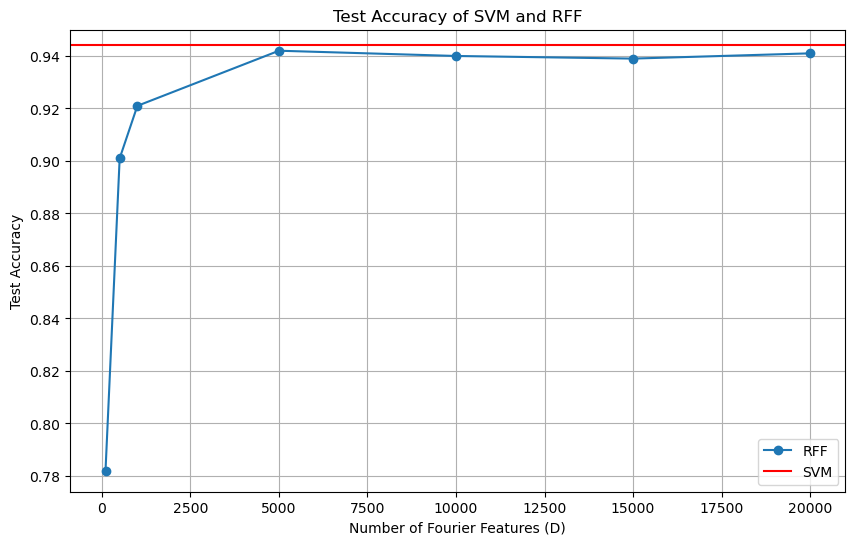

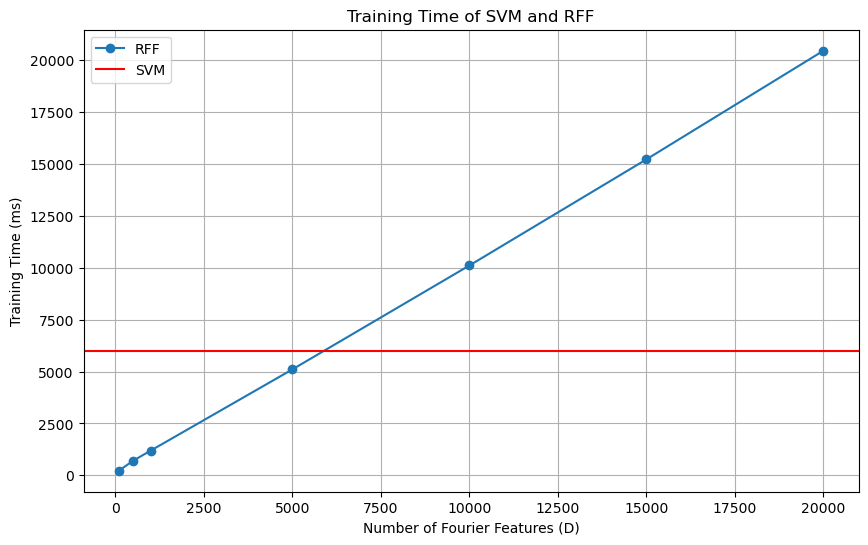

In [56]:
# Train a standard SVM
svm_classifier = SVC(kernel="rbf", gamma="scale")
start_time = time()
svm_classifier.fit(X_train, y_train)
svm_train_time = (time() - start_time) * 1000 # time x 1000 for ms
predicted_svm = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, predicted_svm)
print(svm_accuracy)


# Train RFF classifiers for different values of D
D_values = [100, 500, 1000, 5000, 10000, 15000, 20000]
rff_accuracies = []
rff_train_times = []

for D in D_values:
    start_time = time()
    rbf_feature = RBFSampler(gamma="scale", n_components=D, random_state=250)
    X_features = rbf_feature.fit_transform(X_train)
    clf = SGDClassifier()
    clf.fit(X_features, y_train)
    rff_train_time = (time() - start_time) * 1000
    rff_train_times.append(rff_train_time)

    X_test_features = rbf_feature.transform(X_test)
    predicted = clf.predict(X_test_features)
    accuracy = accuracy_score(y_test, predicted)
    rff_accuracies.append(accuracy)

# Plot for part b
plt.figure(figsize=(10, 6))
plt.plot(D_values, rff_accuracies, marker='o', label="RFF")
plt.axhline(y=svm_accuracy, color='r', linestyle='-', label="SVM")
plt.xlabel("Number of Fourier Features (D)")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy of SVM and RFF")
plt.legend()
plt.grid(True)
plt.show()


# Plot for part c
plt.figure(figsize=(10, 6))
plt.plot(D_values, rff_train_times, marker='o', label="RFF")
plt.axhline(y=svm_train_time, color='r', linestyle='-', label="SVM")
plt.xlabel("Number of Fourier Features (D)")
plt.ylabel("Training Time (ms)")
plt.title("Training Time of SVM and RFF")
plt.legend()
plt.grid(True)
plt.show()



